# Age Interpolation Analysis

Explore latent-space neighbourhoods that preserve the human-rated age dimension.

In [25]:
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import torch
import numpy as np
import pandas as pd
%cd /Users/adamsobieszek/PycharmProjects/_manipy/
# from deixis.face_utils.interpolate.load_interp_data import load_interp_data
import torch

# e.g., allow this process to use at most ~50% of the device’s recommended working set
torch.mps.set_per_process_memory_fraction(1.0)  # call this early, before big allocations

/Users/adamsobieszek/PycharmProjects/_manipy


In [2]:
dim_to_photo_to_rating['age']['453.jpg']

NameError: name 'dim_to_photo_to_rating' is not defined

/var/folders/nc/zbqbbkkx08z7v1g3mlf8bdn00000gn/T/ipykernel_47383/1356868589.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  photo_to_coords = {k: torch.tensor(photo_to_coords[k]).cpu().flatten()[:512] for k in photo_to_coords}


(array([101., 100., 100., 100., 100., 101., 100., 100., 100., 101.]),
 array([   0. ,  100.2,  200.4,  300.6,  400.8,  501. ,  601.2,  701.4,
         801.6,  901.8, 1002. ]),
 <BarContainer object of 10 artists>)

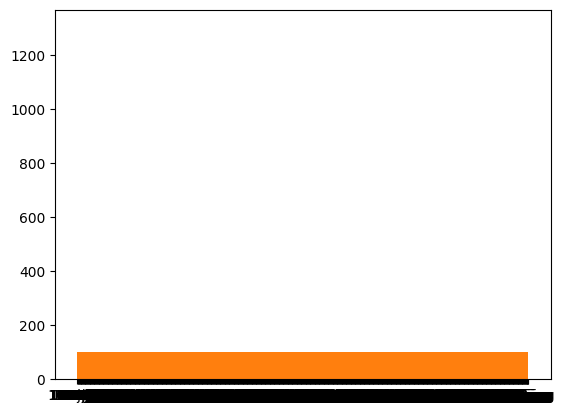

In [ ]:
photo_to_coords, dim_to_photo_to_rating = load_interp_data()
keys = sorted(photo_to_coords.keys()) #sorted(int(m.split('.')[0]) for m in photo_to_coords.keys())
keys = np.array(keys)
plt.hist(keys[1:])

In [20]:
"""Utilities for loading latent priors and covariances for interpolation."""

from __future__ import annotations

import os
import pickle
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, Iterable, Tuple

import pandas as pd
import torch

def bootstrap_tensor(data: torch.Tensor) -> torch.Tensor:
    """
    Performs vectorized bootstrapping on a 2D tensor along the second dimension.
    """
    n_examples = data.shape[1]
    mask = ~torch.isnan(data)
    any_valid_mask = torch.any(mask, dim=1)

    bootstrapped_data = torch.empty_like(data)

    all_nan_mask = ~any_valid_mask
    if torch.any(all_nan_mask):
        bootstrapped_data[all_nan_mask] = torch.full(
            (all_nan_mask.sum(), n_examples), 0.5, device=data.device, dtype=data.dtype
        )

    if torch.any(any_valid_mask):
        data_to_process = data[any_valid_mask]
        mask_to_process = mask[any_valid_mask]

        weights = mask_to_process.float()
        sampled_indices = torch.multinomial(weights, num_samples=n_examples, replacement=True)

        bootstrapped_subset = torch.gather(data_to_process, 1, sampled_indices)
        bootstrapped_data[any_valid_mask] = bootstrapped_subset

    return bootstrapped_data
@dataclass(frozen=True)
class InterpolationData:
    """Container holding latents, covariances, and (optional) ratings."""

    photo_to_coords: Dict[str, torch.Tensor]
    photo_to_covariance: Dict[str, torch.Tensor]
    dim_to_photo_to_rating: Dict[str, Dict[str, float]]



def pad_list(l, max_len):
    return l[:max_len] + [np.nan] * (max_len - len(l[:max_len]))


def load_interp_data(base_dir = "/Users/adamsobieszek/PycharmProjects/PsychGAN/", scale=1) -> Tuple[
    Dict[str, torch.Tensor],
    Dict[str, Dict[str, torch.Tensor]]
]:
    """
    Load latent coordinates, per-image covariance estimates, and ratings.

    Returns:
        (photo_to_coords, photo_to_covariance, dim_to_photo_to_rating)
    """

    base_dir = Path(base_dir)

    p2c_path = base_dir / "newer_photo_to_coords.pt"
    d2p2r_path = base_dir / "dim_to_photo_to_ratings2.pkl"
    with open(d2p2r_path, "rb") as f:
        dim_to_photo_to_ratings = pickle.load(f)
    photo_to_coords = torch.load(p2c_path, map_location="cpu")
    keys = set(sorted(photo_to_coords.keys()))
    photo_to_coords = {k: torch.tensor(photo_to_coords[k]).cpu().flatten()[:512] for k in photo_to_coords}
    for k in dim_to_photo_to_ratings:
        max_len = int(max(len(dim_to_photo_to_ratings[k][kk]) for kk in dim_to_photo_to_ratings[k]) * 2.5)
        dim_to_photo_to_ratings[k] = {kk: bootstrap_tensor(((-0.005 if scale!=1 else 0.0)+torch.tensor(pad_list(dim_to_photo_to_ratings[k][kk], max_len)).reshape(1, -1))*scale).reshape(-1) for kk in dim_to_photo_to_ratings[k]}

    return photo_to_coords, dim_to_photo_to_ratings


def load_interp_dataclass(base_dir = "/Users/adamsobieszek/PycharmProjects/PsychGAN/") -> InterpolationData:
    """Convenience wrapper returning :class:`InterpolationData`."""

    data = load_interp_data(base_dir=base_dir)
    if len(data) == 2:
        return InterpolationData(
            photo_to_coords=data[0],
            photo_to_covariance={},
            dim_to_photo_to_rating=data[1],
        )
    else:
        return InterpolationData(
            photo_to_coords=data[0],
            photo_to_covariance=data[1],
            dim_to_photo_to_rating=data[2],
        )


def subset_priors(
    data: InterpolationData,
    filenames: Iterable[str],
) -> Tuple[Dict[str, torch.Tensor], Dict[str, torch.Tensor]]:
    """
    Restrict priors to a subset of filenames (matching `Path(name).name`).
    """

    names = {Path(name).name for name in filenames}
    coords = {k: v for k, v in data.photo_to_coords.items() if k in names}
    covs = {k: v for k, v in data.photo_to_covariance.items() if k in names}
    return coords, covs


__all__ = [
    "InterpolationData",
    "load_interp_data",
    "load_interp_dataclass",
    "subset_priors",
]



In [8]:
# ================= Unbounded monotone ψ with learned (μ, σ) around logit =================
# - Heteroscedastic per-item variances
# - Strict per-bin Δψ floor (no flat collapses)
# - Adaptive prior in sparse regions
# - (μ, σ) learned via EMA so the logit works comfortably within (0,1)
#
# Requirements: define your `load_interp_data()` in a previous cell
# -----------------------------------------------------------------------------------------

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Dict

# ---------------------------- small helpers ----------------------------
def to_unit(r_int: np.ndarray) -> np.ndarray:
    r_int = np.asarray(r_int, dtype=np.float32)
    y = (r_int + 0.5) / 101.0
    return np.clip(y, 1e-6, 1 - 1e-6)

def safe_tensor(v):
    try: return torch.as_tensor(v)
    except Exception: return torch.tensor(v)

def coerce_dim_dict_to_tensors(dim_to_photo_to_ratings):
    out = {}
    for dim, p2r in dim_to_photo_to_ratings.items():
        inner = {}
        for p, arr in p2r.items():
            t = safe_tensor(arr).detach().cpu().view(-1)
            if t.dtype not in (torch.int64, torch.int32, torch.int16, torch.uint8):
                t = t.to(torch.int64)
            inner[p] = t
        out[dim] = inner
    return out

def validate_loader_output(photo_to_coords, dim_to_photo_to_ratings):
    def looks_like_photo(k: str) -> bool:
        k = str(k).lower()
        return k.endswith('.jpg') or k.endswith('.png') or k.endswith('.jpeg')
    if any(looks_like_photo(k) for k in dim_to_photo_to_ratings.keys()):
        raise RuntimeError("dim_to_photo_to_ratings must be {dimension: {photo: ratings}}.")
    return photo_to_coords, coerce_dim_dict_to_tensors(dim_to_photo_to_ratings)

def diffuse(vec, eps):
    if eps <= 0: return vec
    left = np.zeros_like(vec); right = np.zeros_like(vec)
    left[1:]  = vec[:-1]
    right[:-1]= vec[1:]
    return np.maximum(0.0, (1-2*eps)*vec + eps*(left + right))

def weighted_isotonic(y_vals, w_vals):
    """
    Weighted PAV on an ordered grid (we operate on the 0..100 rating bins).
    Returns fitted nondecreasing values (NaNs remain if all weights zero; caller fills).
    """
    mask = w_vals > 0
    y = y_vals[mask]
    w = w_vals[mask]
    if y.size == 0:
        return np.full_like(y_vals, np.nan, dtype=float)

    block_y = y.astype(float).tolist()
    block_w = w.astype(float).tolist()
    block_idx = list(range(len(y)))

    i = 0
    while i < len(block_y) - 1:
        if block_y[i] > block_y[i+1]:
            wy = block_w[i]*block_y[i] + block_w[i+1]*block_y[i+1]
            ww = block_w[i] + block_w[i+1]
            block_y[i] = wy / (ww + 1e-12)
            block_w[i] = ww
            del block_y[i+1]; del block_w[i+1]; del block_idx[i+1]
            if i > 0: i -= 1
        else:
            i += 1

    y_fit_masked = np.empty_like(y)
    for b in range(len(block_y)):
        s = block_idx[b]
        e = block_idx[b+1] if b+1 < len(block_y) else len(y_fit_masked)
        y_fit_masked[s:e] = block_y[b]

    y_fit_full = np.full_like(y_vals, np.nan, dtype=float)
    y_fit_full[mask] = y_fit_masked
    return y_fit_full

def fill_nearest(y_fit, low=None, high=None):
    y = y_fit.copy()
    idx = np.where(~np.isnan(y))[0]
    if idx.size == 0:
        y = np.linspace(0.0, 1.0, len(y))
    else:
        first, last = idx[0], idx[-1]
        for i in range(first-1, -1, -1): y[i] = y[i+1]
        for i in range(last+1, len(y)):  y[i] = y[i-1]
    if low is not None or high is not None:
        low  = -np.inf if low  is None else low
        high =  np.inf if high is None else high
        y = np.clip(y, low, high)
    return y

def logit(p):
    p = np.clip(p, 1e-12, 1 - 1e-12)
    return np.log(p) - np.log(1 - p)

# ---------------------------- main training ----------------------------
def train_unbounded_monotone_mapping(
    dim_to_photo_to_ratings: Dict[str, Dict[str, torch.Tensor]],
    dimension_name_hint: str = "age",
    *,
    min_ratings: int = 10,
    max_iters: int = 180,
    tol: float = 1e-6,
    sigma_floor: float = 1e-4,     # heteroscedastic noise floor
    neighbor_diffusion: float = 0.15,
    prior_strength: float = 3.0,   # adaptive prior against sparse tails
    prior_power: float = 1.0,
    prior_center: str = "linear_u",   # or "previous"
    min_delta_per_bin: float = 6e-4,  # strict per-interval minimum slope (no flats)
    adaptive_floor_mass: float = 0.02,
    baseline_from: str = "counts",
    eps: float = 1.0/202.0,        # clamp before logit (≈ half a rating bin)
    ema_rate: float = 0.25,        # EMA update rate for (mu, sigma)
    sigma_min_logit: float = 0.35  # keep σ safely away from 0
):
    # ---- pick dimension & collect data ----
    dims = list(dim_to_photo_to_ratings.keys())
    dim = next((d for d in dims if dimension_name_hint.lower() in d.lower()), dims[0])
    p2r = dim_to_photo_to_ratings[dim]

    def looks_like_target(p):
        try:
            base = Path(p).stem
            n = int(base)
            return 1 <= n <= 1004
        except Exception:
            return False

    photos = sorted([p for p,t in p2r.items() if len(t) >= min_ratings and looks_like_target(p)])
    if not photos:
        photos = sorted([p for p,t in p2r.items() if len(t) >= min_ratings])
    I = len(photos)
    if I == 0:
        raise RuntimeError("No photos with sufficient ratings.")

    photo_idx = {p:i for i,p in enumerate(photos)}
    R_all, idx_i = [], []
    for p in photos:
        r = p2r[p].detach().cpu().numpy().astype(np.int32)
        R_all.append(r)
        idx_i.extend([photo_idx[p]]*len(r))
    R_all = np.concatenate(R_all, axis=0)   # integers 0..100
    idx_i = np.asarray(idx_i, dtype=np.int32)
    n_i = np.bincount(idx_i, minlength=I).astype(np.int32)

    grid_r = np.arange(0, 101, dtype=np.int32)
    y_grid = (grid_r + 0.5) / 101.0

    # initialize μ, σ from the raw y distribution
    y_all = to_unit(R_all)
    mu = float(y_all.mean())
    sig = float(y_all.std(ddof=0))
    sig = max(sig, sigma_min_logit)

    # Initialize ψ on bins (unbounded scale), start ~ standardized logit of an initial affine map
    s0 = np.clip(0.5 + (y_grid - mu)/max(sig, 1e-12), eps, 1 - eps)
    u_grid = logit(s0)
    u_grid = (u_grid - u_grid.mean()) / (u_grid.std(ddof=0) + 1e-12)
    psi_bins = u_grid.copy()

    Theta = np.zeros(I, dtype=np.float64)
    sigma2 = np.ones(I, dtype=np.float64) * max(sigma_floor**2, 1e-6)

    C_r_raw = np.bincount(R_all, minlength=101).astype(np.float64)
    C_r_smooth = diffuse(C_r_raw, neighbor_diffusion)

    # Per-interval floor b_inc (length 100) to ensure Δψ >= b_r > 0 everywhere
    Ninc = 100
    floor_uniform = np.full(Ninc, min_delta_per_bin, dtype=float)
    if adaptive_floor_mass > 0:
        if baseline_from == "counts":
            density = C_r_smooth[:-1] + 1.0
        else:
            density = np.ones(Ninc, dtype=float)
        density = density / (density.sum() + 1e-12)
        floor_adapt = adaptive_floor_mass * density
    else:
        floor_adapt = 0.0
    b_inc = floor_uniform + floor_adapt
    B_cum = np.concatenate([[0.0], np.cumsum(b_inc)])  # length 101

    prev_obj = None
    for it in range(max_iters):
        # --- current u_grid with (mu, sig)
        s = 0.5 + (y_grid - mu)/max(sig, 1e-12)
        s_clamped = np.clip(s, eps, 1 - eps)
        u_grid = logit(s_clamped)
        u_std = (u_grid - u_grid.mean()) / (u_grid.std(ddof=0) + 1e-12)

        # ---- A-step: Θ (item locations on ψ-scale)
        z_all = psi_bins[R_all]
        sum_z = np.bincount(idx_i, weights=z_all, minlength=I).astype(np.float64)
        Theta = sum_z / np.maximum(n_i, 1)
        Theta = (Theta - Theta.mean()) / (Theta.std(ddof=0) + 1e-12)

        # ---- S-step: σ² (heteroscedastic per item)
        res = z_all - Theta[idx_i]
        sum_res2 = np.bincount(idx_i, weights=res*res, minlength=I).astype(np.float64)
        sigma2_mle = sum_res2 / np.maximum(n_i, 1)
        sigma2 = np.maximum(sigma2_mle, sigma_floor**2)

        # ---- B-step: ψ via isotonic on residual φ = ψ - B (enforces Δψ >= b_inc)
        w_i = 1.0 / (sigma2 + 1e-12)
        wi_obs = w_i[idx_i]
        # aggregate to rating bins
        T_r = np.bincount(R_all, weights=wi_obs*Theta[idx_i], minlength=101).astype(np.float64)
        W_r = np.bincount(R_all, weights=wi_obs,               minlength=101).astype(np.float64)
        T_r = diffuse(T_r, neighbor_diffusion)
        W_r = diffuse(W_r, neighbor_diffusion)

        # Prior center for ψ
        if prior_center == "previous":
            prior_mu_psi = psi_bins.copy()
        else:  # "linear_u": affine fit of ψ to u_std (weighted by W_r)
            mask_w = W_r > 0
            if mask_w.any():
                x0 = np.ones_like(u_std[mask_w])
                x1 = u_std[mask_w]
                X = np.stack([x0, x1], axis=1)
                w = W_r[mask_w]
                Y = psi_bins[mask_w]
                # weighted normal equations
                XtW = X.T * w
                H = XtW @ X + 1e-8 * np.eye(2)
                bvec = XtW @ Y
                a_lin, b_lin = np.linalg.solve(H, bvec)
            else:
                a_lin, b_lin = 0.0, 1.0
            prior_mu_psi = a_lin + b_lin * u_std

        # Adaptive prior strength (stronger in sparse bins)
        C_med = np.median(C_r_raw[C_r_raw>0]) if np.any(C_r_raw>0) else 1.0
        W_nonzero = W_r[W_r>0]
        W_med = np.median(W_nonzero) if W_nonzero.size>0 else 1.0
        alpha_r = prior_strength * W_med * (C_med / (C_r_raw + 1.0))**prior_power
        alpha_r = np.clip(alpha_r, 0.0, 10.0 * W_med)

        # Targets for φ: subtract baseline
        prior_mu_phi = prior_mu_psi - B_cum
        m_r_phi_num  = T_r - W_r * B_cum + alpha_r * prior_mu_phi
        W_r_phi      = W_r + alpha_r
        with np.errstate(divide='ignore', invalid='ignore'):
            m_r_phi = m_r_phi_num / np.maximum(W_r_phi, 1e-12)

        # Isotonic fit for φ (nondecreasing), no endpoint constraints (unbounded)
        phi_fit = weighted_isotonic(m_r_phi, W_r_phi)
        phi_fit = fill_nearest(phi_fit, low=None, high=None)

        # Recover ψ and guarantee nondecreasing + per-bin floor
        psi_bins = B_cum + phi_fit
        psi_bins = np.maximum.accumulate(psi_bins)

        # ---- (μ, σ) rescaling update (Gauss–Newton step, then EMA) ----
        # We align ψ ≈ a + b * u(μ,σ) by WLS, then update (μ,σ) to reduce residuals.
        # Disable (no gradient) bins where the pre-logit affine would go outside (0,1).
        mask_valid = (s > eps) & (s < 1 - eps) & (W_r > 0)
        if np.any(mask_valid):
            W = W_r[mask_valid]
            u = u_grid[mask_valid]     # unstandardized logit for alignment
            ypsi = psi_bins[mask_valid]

            # Fit a,b by WLS: ypsi ≈ a + b*u
            X = np.stack([np.ones_like(u), u], axis=1)
            XtW = X.T * W
            H_ab = XtW @ X + 1e-8*np.eye(2)
            b_ab = XtW @ ypsi
            a_hat, b_hat = np.linalg.solve(H_ab, b_ab)

            # Residuals
            r = ypsi - (a_hat + b_hat*u)

            # Jacobians of u wrt μ, σ on valid bins
            sval = s[mask_valid]
            denom = sval*(1 - sval)
            denom = np.clip(denom, 1e-12, None)
            du_dmu  = -(1.0/max(sig,1e-12)) / denom
            du_dsig = -((y_grid[mask_valid] - mu)/max(sig,1e-12)**2) / denom

            # Build 2x2 normal equations for Δθ = [Δμ, Δσ]
            J0 = b_hat * du_dmu
            J1 = b_hat * du_dsig
            # H = J^T W J, g = J^T W r
            H00 = np.sum(W * J0 * J0)
            H01 = np.sum(W * J0 * J1)
            H11 = np.sum(W * J1 * J1)
            g0  = np.sum(W * J0 * r)
            g1  = np.sum(W * J1 * r)
            H = np.array([[H00, H01],
                          [H01, H11]], dtype=float)
            g = np.array([g0, g1], dtype=float)
            # Damped solve (Levenberg–Marquardt)
            lam = 1e-6 * (np.trace(H) + 1e-12)
            try:
                dmu, dsig = np.linalg.solve(H + lam*np.eye(2), g) * 1.0
            except np.linalg.LinAlgError:
                dmu, dsig = 0.0, 0.0

            # EMA update (small step)
            mu_new  = mu  + ema_rate * dmu
            sig_new = max(sig + ema_rate * dsig, sigma_min_logit)
            # Optional: prevent exploding σ
            sig_new = float(np.clip(sig_new, sigma_min_logit, 5.0))

            mu, sig = float(mu_new), float(sig_new)

        # ---- Objective (profile likelihood + prior penalty) ----
        z_all = psi_bins[R_all]
        res = z_all - Theta[idx_i]
        sum_res2 = np.bincount(idx_i, weights=res*res, minlength=I).astype(np.float64)
        sigma2 = np.maximum(sum_res2 / np.maximum(n_i, 1), sigma_floor**2)
        like = 0.5 * np.sum((sum_res2 / np.maximum(sigma2, 1e-12)) + n_i * np.log(np.maximum(sigma2, 1e-12)))
        prior_pen = 0.5 * np.sum(alpha_r * ( (psi_bins - B_cum) - (prior_mu_psi - B_cum) )**2 )
        obj = like + prior_pen

        if prev_obj is not None and abs(prev_obj - obj) / (abs(prev_obj) + 1e-12) < tol:
            break
        prev_obj = obj

    # ---- outputs ----
    psi_table = pd.DataFrame({
        "rating_int": grid_r,      # 101
        "y_unit": y_grid,          # 101
        "psi": psi_bins,           # 101
        "bin_count": C_r_raw,      # 101
        "alpha_prior": alpha_r,    # 101
        "baseline_cum": B_cum,     # 101
        "u_logit_mu_sigma": logit(np.clip(0.5 + (y_grid - mu)/max(sig,1e-12), eps, 1-eps))
    })

    Theta_df = pd.DataFrame({
        "photo": photos,
        "Theta": Theta,
        "sigma": np.sqrt(sigma2),
        "n": n_i
    })

    # diagnostics
    def spearman(x, y):
        xr = x.argsort().argsort().astype(np.float64)
        yr = y.argsort().argsort().astype(np.float64)
        xr = (xr - xr.mean()) / (xr.std(ddof=0) + 1e-12)
        yr = (yr - yr.mean()) / (yr.std(ddof=0) + 1e-12)
        return float(np.clip((xr * yr).mean(), -1.0, 1.0))

    raw_means, raw_sds = [], []
    for p in Theta_df["photo"]:
        r = dim_to_photo_to_ratings[dim][p].detach().cpu().numpy().astype(np.int32)
        y = to_unit(r)
        raw_means.append(y.mean())
        raw_sds.append(y.std(ddof=1) if y.size>1 else 0.0)
    raw_means = np.asarray(raw_means); raw_sds = np.asarray(raw_sds)

    dpsi = np.diff(psi_bins)
    diagnostics = dict(
        iterations = it+1,
        obj = float(obj),
        spearman_mean_sd_pre  = spearman(raw_means, raw_sds),
        spearman_mean_sd_post = spearman(Theta_df["Theta"].values, Theta_df["sigma"].values),
        mean_sigma = float(np.mean(Theta_df["sigma"].values)),
        median_sigma = float(np.median(Theta_df["sigma"].values)),
        dimension = dim,
        min_delta_per_bin = float(min_delta_per_bin),
        adaptive_floor_mass = float(adaptive_floor_mass),
        total_floor = float(b_inc.sum()),
        min_delta = float(dpsi.min()),
        floor_min = float(b_inc.min()),
        violates_floor = bool((dpsi < b_inc - 1e-12).any()),
        mu = float(mu),
        sigma = float(sig)
    )

    return dict(
        dimension=dim,
        psi_table=psi_table,
        Theta=Theta_df,
        diagnostics=diagnostics,
        baseline_inc=b_inc
    )

# ---------------------------- run + visualize ----------------------------
# Requires your `load_interp_data(scale=101)` from a previous cell.
photo_to_coords, dim_to_photo_to_ratings = load_interp_data(scale=101)
photo_to_coords, dim_to_photo_to_ratings = validate_loader_output(photo_to_coords, dim_to_photo_to_ratings)

results = train_unbounded_monotone_mapping(
    dim_to_photo_to_ratings,
    max_iters = 1_000,
    dimension_name_hint="age",      # change to your target dimension
    min_ratings=10,
    min_delta_per_bin=6e-4,
    adaptive_floor_mass=0.02,
    prior_strength=3.0,
    prior_power=1.0,
    neighbor_diffusion=0.01,
    ema_rate=0.2,
    sigma_min_logit=0.25
)

psi_table = results["psi_table"]
Theta_df  = results["Theta"]
diagn     = results["diagnostics"]
dim_name  = results["dimension"]
b_inc     = results["baseline_inc"]

print("Diagnostics:", diagn)

# ψ vs identity-like baselines
x = psi_table["y_unit"].values
y = psi_table["psi"].values
B = psi_table["baseline_cum"].values
ulog = psi_table["u_logit_mu_sigma"].values

fig, ax = plt.subplots(1,1, figsize=(6.8,4.6))
ax.plot(x, y, lw=2, label="ψ (unbounded, Δψ floor)")
ax.plot(x, B, lw=1, alpha=0.7, label="baseline (cum)")
# ax.plot(x, (ulog - ulog.mean())/(ulog.std(ddof=0)+1e-12), lw=1, alpha=0.8, label="standardized logit(μ,σ)")
ax.set_xlabel("raw scale y"); ax.set_ylabel("latent scale")
ax.set_title(f"Monotone ψ on unbounded scale — {dim_name}")
ax.legend(); plt.tight_layout(); plt.show()

# Δψ and support / prior
dpsi = np.diff(y)
mid  = (x[:-1] + x[1:]) / 2.0
fig, ax = plt.subplots(2,1, figsize=(7.6,6.4), sharex=True)
ax[0].plot(mid, dpsi, lw=1.6, label="Δψ per bin")
ax[0].plot(mid, b_inc, lw=1.1, alpha=0.8, label="per-bin floor b_r")
ax[0].set_ylabel("Δψ"); ax[0].legend()
ax[1].bar(x, psi_table["bin_count"].values, width=1/101, alpha=0.55, label="bin count")
ax[1].plot(x, psi_table["alpha_prior"].values, lw=1.2, label="prior weight α_r")
ax[1].set_xlabel("raw scale y"); ax[1].set_ylabel("support / prior"); ax[1].legend()
plt.tight_layout(); plt.show()

# Save CSVs
out_dir = Path("./scale_learning_unbounded_logit_ema")
out_dir.mkdir(parents=True, exist_ok=True)
psi_table.to_csv(out_dir / f"psi_lookup_{dim_name}_unbounded.csv", index=False)
Theta_df.to_csv(out_dir / f"Theta_sigma_{dim_name}_unbounded.csv", index=False)
print("Saved to:", out_dir)


NameError: name 'load_interp_data' is not defined

In [9]:
photo_to_coords, dim_to_photo_to_rating = load_interp_data()

def pad_list(l, max_len):
    return l[:max_len] + [np.nan] * (max_len - len(l[:max_len]))
age_key = None
for key in dim_to_photo_to_rating:
    if key.lower().startswith("age"):
        age_key = key
        break

if age_key is None:
    raise KeyError("Could not find an age rating key in the dataset.")
age_ratings = dim_to_photo_to_rating[age_key]
imgs = [f'{i}.jpg' for i in range(1, 1005)]
dim_to_tensor_of_means = {}
for dim in dim_to_photo_to_rating:
    ys = dim_to_photo_to_rating[dim]
    print(ys)
    max_len = max([len(ys[k]) for k in imgs])
    y = torch.tensor([pad_list(ys[k], max_len) for k in imgs], device=torch.device("mps"), dtype=torch.float32)
    dim_to_tensor_of_means[dim] = y.mean(dim=0)

print(f"Using rating column: {age_key}")
print(f"Total latent samples: {len(photo_to_coords)}")
print(f"Total age ratings: {len(age_ratings)}")

NameError: name 'load_interp_data' is not defined

In [10]:
shared_keys = sorted(set(photo_to_coords).intersection(age_ratings))
print(f"Samples with both latent and age rating: {len(shared_keys)}")

latents = torch.stack([
    photo_to_coords[key].detach().cpu().float() if hasattr(photo_to_coords[key], "detach")
    else torch.as_tensor(photo_to_coords[key], dtype=torch.float32)
    for key in shared_keys
])

ages = torch.tensor([np.mean(age_ratings[key]) for key in shared_keys], dtype=torch.float32)
age_mean = ages.mean().item()
print(f"Latent matrix shape: {latents.shape}")
print(f"Age mean: {age_mean:.2f}")

NameError: name 'photo_to_coords' is not defined

In [11]:
with torch.no_grad():
    latent_dist = torch.cdist(latents, latents, p=2)
    age_dist = torch.cdist(ages.unsqueeze(1), ages.unsqueeze(1), p=1)

latent_dist_np = latent_dist.numpy()
age_dist_np = age_dist.numpy()

print(f"Latent distance matrix shape: {latent_dist_np.shape}")
print(f"Age distance matrix shape: {age_dist_np.shape}")
print(
    f"Average latent distance: {latent_dist_np[np.triu_indices_from(latent_dist_np, k=1)].mean():.3f}"
)
print(
    f"Average age difference: {age_dist_np[np.triu_indices_from(age_dist_np, k=1)].mean():.3f}"
)

NameError: name 'latents' is not defined

In [12]:
df_pairs = []
upper_idx = np.triu_indices_from(latent_dist_np, k=1)
for i, j in zip(*upper_idx):
    df_pairs.append(
        {
            "src": shared_keys[i],
            "dst": shared_keys[j],
            "latent_distance": latent_dist_np[i, j],
            "age_diff": age_dist_np[i, j],
        }
    )

pairs_df = pd.DataFrame(df_pairs)
pairs_df["combined_rank"] = (
    pairs_df["latent_distance"].rank(method="average") +
    pairs_df["age_diff"].rank(method="average")
)

top_pairs = pairs_df.nsmallest(10, "combined_rank")
top_pairs

NameError: name 'latent_dist_np' is not defined

In [13]:
from manipy.stylegan.core import setup_stylegan  # type: ignore
G,_,_ = setup_stylegan()
w_avg = G.mapping.w_avg.cpu()
w_avg_tensor = G.mapping.w_avg.cpu()
print('Loaded w_avg from StyleGAN utilities.')


sh: gdown: command not found
fatal: destination path 'omi' already exists and is not an empty directory.
unzip:  cannot find or open content/omi/attribute_ratings.zip, content/omi/attribute_ratings.zip.zip or content/omi/attribute_ratings.zip.ZIP.


Loaded w_avg from StyleGAN utilities.


In [14]:
import sys
from PIL import Image
from torch.utils.data import Dataset, DataLoader
sys.path.append('/Users/adamsobieszek/PycharmProjects/_manipy/deixis/pixel2style2pixel/')
from deixis.pixel2style2pixel.criteria.id_loss import IDLoss
from deixis.pixel2style2pixel.utils import data_utils

class ImagesDataset(Dataset):

	def __init__(self, source_root, source_transform=None):
		self.source_paths = sorted(data_utils.make_dataset(source_root), key=lambda x: int(x.split('/')[-1].split('.')[0]))
		self.source_transform = source_transform

	def __len__(self):
		return len(self.source_paths)

	def __getitem__(self, index):
		from_path = self.source_paths[index]
		from_im = Image.open(from_path)
		from_im = from_im.convert('RGB')

		if self.source_transform:
			from_im = self.source_transform(from_im)

		return from_im, from_path

def collate_fn(batch):
    from torchvision.transforms.functional import to_tensor
    return torch.stack([to_tensor(item[0]) for item in batch]), [item[1].split('/')[-1] for item in batch]

# im_dataset = ImagesDataset(source_root="/Users/adamsobieszek/Downloads/0.75", source_transform=None)
# im_dataloader = DataLoader(im_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)
# idloss = IDLoss(device='mps')
# device = torch.device('mps')
# good_paths = [f'{i}.jpg' for i in range(1, 1005)]
# feats = []
# feat_paths = []
# with torch.no_grad():
#     for imgs, paths in im_dataloader:
#         if all(path not in good_paths for path in paths):
#             continue
#         # x = idloss.extract_feats(G.synthesis(latents.reshape(-1,1,512).expand(-1,18,512).to(device), noise_mode='const'))
#         x = idloss.extract_feats(imgs.to(device))
#         feats.append(x[:len([p for p in paths if p in good_paths])])
#         feat_paths.extend([p for p in paths if p in good_paths])
# feats = torch.cat(feats)
# print(feats.shape)




ModuleNotFoundError: No module named 'deixis'

### Interpreting Spherical Metrics
- **Local spherical age** averages neighbour ages chosen by cosine proximity once centered at `w_avg`; stable plateaus indicate likely linear regions.
- **Nearest distance** captures sparsity: high values suggest extrapolation risk.
- **Local variance** highlights disagreement among nearby neighbours; low variance means confident interpolation.
- **Spherical confidence** combines both factors (distance and variance) via exponential decay so values near 1.0 signal trustworthy age estimates.
Use `spherical_df` to inspect or sort by confidence when selecting candidate interpolation paths.


In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.express as px

latents_np = latents.numpy() #feats.cpu().numpy()#
ages_np = ages.numpy()

pca = PCA(n_components=2, random_state=42)
latent_pca = pca.fit_transform(latents_np)

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca', random_state=42)
latent_tsne = tsne.fit_transform(latents_np)

projection_df = pd.DataFrame({
    'photo': shared_keys,
    'age': ages_np,
    'pca_x': latent_pca[:, 0],
    'pca_y': latent_pca[:, 1],
    'tsne_x': latent_tsne[:, 0],
    'tsne_y': latent_tsne[:, 1],
})

fig_pca = px.scatter(
    projection_df,
    x='pca_x',
    y='pca_y',
    color='age',
    color_continuous_scale='Viridis',
    title='PCA projection of latent space coloured by age',
)
fig_pca.show()

fig_tsne = px.scatter(
    projection_df,
    x='tsne_x',
    y='tsne_y',
    color='age',
    color_continuous_scale='Viridis',
    title='t-SNE projection of latent space coloured by age',
)
fig_tsne.show()


In [ ]:

#latents - w_avg
latents_centered = latents - w_avg#feats.cpu() 
norms = latents_centered.norm(dim=1, keepdim=True).clamp_min(1e-6)
latents_centered_norm = norms.mean().item()
unit_latents = latents_centered / norms

cosine_sim = unit_latents @ unit_latents.t()
cosine_sim.fill_diagonal_(-1.0)



k_neighbors = 8 #min(32, len(shared_keys) - 1)
cosine_vals, cosine_idx = torch.topk(cosine_sim, k=k_neighbors, dim=1)
weights = torch.relu(cosine_vals)
weight_sums = weights.sum(dim=1, keepdim=True).clamp_min(1e-6)
normalized_weights = weights / weight_sums
neighbor_ages = ages[cosine_idx]
local_spherical_age = (normalized_weights * neighbor_ages).sum(dim=1)

distance_subset = latent_dist[torch.arange(len(latents)).unsqueeze(1), cosine_idx]
local_variance = (normalized_weights * (neighbor_ages - local_spherical_age.unsqueeze(1))**2).sum(dim=1)
density_distance = (normalized_weights * distance_subset).sum(dim=1)

alpha = density_distance.mean().item() + 1e-6
beta = local_variance.mean().item() + 1e-6
spherical_confidence = torch.exp(-density_distance / alpha) * torch.exp(-local_variance / beta)

spherical_df = pd.DataFrame({
    'photo': shared_keys,
    'age': ages.numpy(),
    'local_spherical_age': local_spherical_age.numpy(),
    'density_distance': density_distance.numpy(),
    'local_variance': local_variance.numpy(),
    'spherical_confidence': spherical_confidence.numpy(),
})
spherical_df.sort_values('spherical_confidence', ascending=True).head()


,photo,age,local_spherical_age,density_distance,local_variance,spherical_confidence
949,95.jpg,0.648756,0.420754,14.167392,0.056285,0.000661
737,759.jpg,0.367628,0.377340,14.465364,0.040922,0.003483
219,292.jpg,0.417492,0.250556,12.107061,0.042361,0.003598
669,698.jpg,0.572419,0.200634,12.909315,0.041096,0.003875
158,237.jpg,0.372850,0.389396,12.849469,0.039616,0.004581


In [ ]:
import pickle
from configs.paths_config import model_paths
from models.encoders.model_irse import Backbone

# 1) prepare keys + ratings
keys = [f"{i}.jpg" for i in range(1, 1005)]
attr_names, Y, mask = build_attribute_tensors(dim_to_photo_to_ratings, keys)

# 2) configure + fit
cfg = SphericalConfig(
    image_root="/Users/adamsobieszek/Downloads/0.75",
    irse50_weights=model_paths['ir_se50'],
    keys=keys,
    dims=(32, 64, 128),
    epochs=250,
    lr_backbone=1e-5,
    lr_head=3e-3,
    batch_size_embed=96,
    freeze_backbone=False,   # unfreeze ArcFace
    unfreeze_after=10,        # from the start
    topk=None,                # None => full vMF softmax; set 128 to sparsify
    log_dir="runs/spherical", run_name_prefix="subspace", tb_hist_every=5.
)
# trainer = MultitaskSphericalTrainer(cfg, Backbone, model_paths['ir_se50'], attr_names, Y, mask)
trainer.fit()
exp = trainer.export_projection()
print("best d:", exp["best_dim"], "kappa:", exp["kappa"])

# 3) get a spherical_df for any attribute (e.g., 'age')
df_age = trainer.spherical_df_for_attr("age")
print(df_age.sort_values("spherical_confidence", ascending=False).head())

NameError: name 'dim_to_photo_to_ratings' is not defined

In [21]:
# Multitask spherical subspace training (MPS) with optional ArcFace unfreezing
# - Learns a shared linear projection W: R^512 -> R^d (and optionally fine-tunes ArcFace)
# - Optimizes a vMF (softmax(cos*kappa)) spherical interpolation objective across MANY attributes
#   by cycling which attribute is used as the supervision target each step.
# - Safe for small-N datasets (~1004 images). Uses an all-train-neighbors protocol for validation.
# - Runs on Apple Silicon via torch.mps when available.

from __future__ import annotations
import os, math, time, random
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional, Sequence

import numpy as np
import pandas as pd

import torch
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# =============================================================
# Device + dtype
# =============================================================

def get_device():
    return torch.device("mps") if torch.backends.mps.is_available() else torch.device('mps') if torch.backends.mps.is_available() else torch.device("cpu")

DEVICE = get_device()
DTYPE  = torch.float32

torch.set_default_dtype(DTYPE)

# =============================================================
# ArcFace backbone wrapper (IR-SE50) with the same preproc as your IDLoss.extract_feats
# =============================================================

class ArcFaceBackbone(nn.Module):
    def __init__(self, backbone_cls, weight_path: str, trainable: bool = False):
        super().__init__()
        self.backbone = backbone_cls(input_size=112, num_layers=50, drop_ratio=0.6, mode='ir_se')
        state = torch.load(weight_path, map_location='cpu')
        self.backbone.load_state_dict(state)
        self.face_pool = nn.AdaptiveAvgPool2d((112, 112))
        self.trainable = trainable
        if not trainable:
            for p in self.backbone.parameters():
                p.requires_grad = False
        self.to(DEVICE)

    def preprocess(self, x: torch.Tensor) -> torch.Tensor:
        # x: (B,3,H,W) in [0,1]; mimic your IDLoss.extract_feats steps
        x = F.adaptive_avg_pool2d(x, (256, 256))
        x = x[:, :, 12:12+224, 12:12+224]
        x = self.face_pool(x)
        return x

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.preprocess(x)
        feats = self.backbone(x)  # (B,512)
        return feats

# =============================================================
# Spherical projection + vMF weighting
# =============================================================

class SphericalHead(nn.Module):
    def __init__(self, in_dim: int = 512, out_dim: int = 128):
        super().__init__()
        # Orthonormal init for W
        with torch.no_grad():
            q, _ = torch.linalg.qr(torch.randn(in_dim, out_dim, dtype=DTYPE))
        self.W = nn.Parameter(q.to(DEVICE))
        self._log_kappa = nn.Parameter(torch.tensor(0.0, dtype=DTYPE, device=DEVICE))

    def kappa(self) -> torch.Tensor:
        return F.softplus(self._log_kappa) + 1e-6

    def project(self, x: torch.Tensor) -> torch.Tensor:
        z = x @ self.W  # (N,d)
        return z / z.norm(dim=1, keepdim=True).clamp_min(1e-6)

    def pairwise_cos(self, U: torch.Tensor) -> torch.Tensor:
        return U @ U.T

# =============================================================
# Data utilities: image loader (files named '1.jpg'..'1004.jpg'), ratings dict per attribute
# =============================================================

class OrderedImageFolder(Dataset):
    def __init__(self, root: str, keys: Sequence[str]):
        from PIL import Image
        from torchvision.transforms.functional import to_tensor
        self.root = root
        self.keys = list(keys)
        self.Image = Image
        self.to_tensor = to_tensor

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx):
        k = self.keys[idx]
        path = os.path.join(self.root, k)
        img = self.Image.open(path).convert('RGB').resize((256, 256))
        x = self.to_tensor(img)  # (3,H,W) float in [0,1]
        return x, k

# =============================================================
# Training config
# =============================================================

@dataclass
class SphericalConfig:
    image_root: str
    irse50_weights: str
    keys: Sequence[str]
    # Optimization
    dims: Sequence[int] = (32, 64, 128)
    epochs: int = 250
    lr_backbone: float = 1e-5
    lr_head: float = 3e-3
    weight_decay: float = 1e-4
    patience: int = 30
    batch_size_embed: int = 64
    unfreeze_after: int = 0
    freeze_backbone: bool = False
    # Regularization
    ortho_reg: float = 1e-2
    l2_reg: float = 1e-6
    # Neighbor protocol
    topk: Optional[int] = None
    # Val split
    val_split: float = 0.125
    seed: int = 42
    # TensorBoard
    log_dir: Optional[str] = "runs/spherical"
    run_name_prefix: str = "subspace"
    tb_hist_every: int = 25
    # Contrastive (soft-target InfoNCE-ish)
    contrastive_weight: float = 0.2
    contrastive_sigma: float = 0.05  # labels in (0,1); adjust as needed

# =============================================================
# Multitask spherical objective + (NEW) soft contrastive term from labels
# =============================================================
# =============================================================

def build_attribute_tensors(dim_to_photo_to_ratings: Dict[str, Dict[str, List[float]]],
                            keys: Sequence[str],
                            scale: float = 1.,
                            eps: float = 0.005) -> Tuple[List[str], torch.Tensor, torch.Tensor]:
    """
    Returns (attr_names, Y, mask).
    Y: (A, N) in (0,1) with per-photo mean rating for each attribute.
    mask: (A, N) bool indicating availability (at least one rating).
    """
    photos = list(keys)
    N = len(photos)

    attr_names = list(dim_to_photo_to_ratings.keys())
    A = len(attr_names)

    photo_index = {p: i for i, p in enumerate(photos)}
    min_ratings = 10

    # Build sparse COO buffers for SUMS and COUNTS over the (N,A) grid (photos x attributes)
    row_idx_chunks, col_idx_chunks, sum_chunks, cnt_chunks = [], [], [], []

    for j, attr in enumerate(attr_names):
        table = dim_to_photo_to_ratings[attr]
        if sum(table['1.jpg']>1)>10:
            table = {k:[(vv)/101 for vv in v] for k,v in table.items()}
        if not table:
            continue
        keys_j = list(table.keys())
        rows = np.fromiter((photo_index.get(k, -1) for k in keys_j), count=len(keys_j), dtype=np.int64)
        values_list = list(table.values())
        cnts = np.fromiter((len(v) for v in values_list), count=len(values_list), dtype=np.int64)
        sums = np.fromiter((float(np.sum(v) if not isinstance(v, torch.Tensor) else v.sum()) if len(v) > 0 else 0.0 for v in values_list),
                           count=len(values_list), dtype=np.float32)
        mask_valid = (rows >= 0) & (cnts > 0)
        if not np.any(mask_valid):
            continue
        rows = rows[mask_valid]
        cnts = cnts[mask_valid]
        sums = sums[mask_valid]
        cols = np.full(rows.shape[0], j, dtype=np.int64)
        row_idx_chunks.append(rows)
        col_idx_chunks.append(cols)
        cnt_chunks.append(cnts.astype(np.float32))
        sum_chunks.append(sums.astype(np.float32))

    if len(row_idx_chunks) == 0:
        Y = torch.full((A, N), float('nan'), dtype=torch.float32, device=DEVICE)
        mask = torch.zeros((A, N), dtype=torch.bool, device=DEVICE)
        return attr_names, Y, mask

    rows = np.concatenate(row_idx_chunks)
    cols = np.concatenate(col_idx_chunks)
    cnts = np.concatenate(cnt_chunks)
    sums = np.concatenate(sum_chunks)

    indices = torch.tensor(np.vstack([rows, cols]), dtype=torch.long, device="cpu")
    val_counts = torch.from_numpy(cnts).to(dtype=torch.float32)
    val_sums   = torch.from_numpy(sums).to(dtype=torch.float32)

    sparse_counts = torch.sparse_coo_tensor(indices, val_counts, size=(N, A)).coalesce()
    sparse_sums   = torch.sparse_coo_tensor(indices, val_sums,   size=(N, A)).coalesce()

    counts_dense = sparse_counts.to_dense()  # [N, A] on CPU
    sums_dense   = sparse_sums.to_dense()    # [N, A] on CPU

    with torch.no_grad():
        means = torch.full_like(sums_dense, float('nan'))
        valid = counts_dense >= float(min_ratings)
        means[valid] = sums_dense[valid] / counts_dense[valid]

    # Scale to (0,1) like your training code
    means = (means / scale + eps).clamp(0.01, 0.99)

    # Transpose to (A, N) for the trainer
    Y = means.T.to(device=DEVICE, dtype=DTYPE)
    mask = (~torch.isnan(Y)).to(torch.bool)
    return attr_names, Y, mask


def masked_softmax(scores: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
    NEG = torch.finfo(scores.dtype).min / 4
    scores = scores.masked_fill(~mask, NEG)
    return F.softmax(scores, dim=1)


def soft_label_kernel(y_rows: torch.Tensor,
                      y_cols: torch.Tensor,
                      sigma: float,
                      col_mask: torch.Tensor,
                      eps: float = 1e-6) -> torch.Tensor:
    """Build a soft target distribution p(col|row) from continuous labels.
    y_rows: (B,) labels for batch rows
    y_cols: (N,) labels for bank columns
    col_mask: (N,) bool selecting valid neighbor columns
    Returns p: (B,N) with masked columns zeroed and rows normalized.
    """
    delta = (y_rows.unsqueeze(1) - y_cols.unsqueeze(0)).abs()  # (B,N)
    K = torch.exp(- (delta * delta) / (2.0 * (sigma ** 2)))
    K = K * col_mask.unsqueeze(0).float()
    Ksum = K.sum(dim=1, keepdim=True).clamp_min(eps)
    return K / Ksum


def spherical_predict_for_target(U: torch.Tensor,
                                 y_vec: torch.Tensor,    # (N,)
                                 train_mask_cols: torch.Tensor,  # (N,) bool: which columns allowed as neighbors
                                 self_exclude_rows: Optional[torch.Tensor] = None, # (N,) bool rows to exclude diagonal
                                 kappa: float = 1.0,
                                 topk: Optional[int] = None) -> torch.Tensor:
    """Compute vMF-averaged prediction for each row using allowed neighbor columns."""
    S = U @ U.T  # (N,N)
    if self_exclude_rows is not None:
        S = S.clone()
        S[torch.arange(U.shape[0], device=U.device), torch.arange(U.shape[0], device=U.device)] = -1.0
    kappa_t = torch.as_tensor(kappa, dtype=U.dtype, device=U.device)
    scores = S * kappa_t

    # broadcast masks to (N,N)
    col_mask = train_mask_cols.unsqueeze(0).expand(U.shape[0], U.shape[0])

    if topk is not None:
        # restrict to topk per row
        vals, idx = torch.topk(scores, k=min(topk, U.shape[0]-1), dim=1)
        row_idx = torch.arange(U.shape[0], device=U.device).unsqueeze(1).expand_as(idx)
        sparse = torch.full_like(scores, torch.finfo(scores.dtype).min / 4)
        sparse[row_idx, idx] = vals
        scores = sparse

    W = masked_softmax(scores, col_mask)
    y_pred = W @ y_vec
    return y_pred

# =============================================================
# Trainer
# =============================================================

class MultitaskSphericalTrainer:
    def __init__(self, cfg: SphericalConfig, backbone_cls, weight_path: str,
                 attr_names: List[str], Y: torch.Tensor, mask: torch.Tensor):
        self.cfg = cfg
        self.attr_names = attr_names
        self.Y = Y  # (A,N)
        self.mask = mask  # (A,N)
        self.N = Y.shape[1]
        self.A = Y.shape[0]
        self.keys = list(cfg.keys)
        self.key_to_idx = {k:i for i,k in enumerate(self.keys)}

        # Split photos into train/val once
        torch.manual_seed(cfg.seed)
        perm = torch.randperm(self.N)
        n_val = max(1, int(cfg.val_split * self.N))
        self.val_idx = perm[:n_val]
        self.train_idx = perm[n_val:]
        self.train_cols_mask = torch.zeros((self.N,), dtype=torch.bool, device=DEVICE)
        self.train_cols_mask[self.train_idx] = True

        # Backbone
        self.backbone = ArcFaceBackbone(backbone_cls, weight_path, trainable=(not cfg.freeze_backbone))

        # (NEW) Initialize ALL heads upfront and single optimizer with groups
        self.heads: Dict[int, SphericalHead] = {d: SphericalHead(512, d).to(DEVICE) for d in cfg.dims}
        param_groups = []
        if not cfg.freeze_backbone:
            param_groups.append({"params": [p for p in self.backbone.parameters() if p.requires_grad],
                                 "lr": cfg.lr_backbone, "weight_decay": cfg.weight_decay})
        for d, head in self.heads.items():
            param_groups.append({"params": [head.W, head._log_kappa], "lr": cfg.lr_head, "weight_decay": cfg.weight_decay})
        self.opt = torch.optim.AdamW(param_groups)

        # TensorBoard
        self.writer = SummaryWriter(os.path.join(cfg.log_dir, cfg.run_name_prefix)) if cfg.log_dir else None

        # Tracking best per dimension
        self.best_per_dim: Dict[int, Dict] = {d: {"val": float('inf'), "state": None, "no_imp": 0} for d in cfg.dims}
        self.best: Dict = {}

    def _build_loader(self, keys: Sequence[str]) -> DataLoader:
        ds = OrderedImageFolder(self.cfg.image_root, keys)
        return DataLoader(ds, batch_size=self.cfg.batch_size_embed, shuffle=False, num_workers=0)

    @torch.no_grad()
    def _embed_bank(self) -> torch.Tensor:
        """Compute features for ALL images without grad (memory-friendly). Returns F_bank: (N,512)."""
        loader = self._build_loader(self.keys)
        self.backbone.eval()
        feats = []
        for xb, names in loader:
            xb = xb.to(DEVICE, DTYPE)
            fb = self.backbone(xb)
            feats.append(fb)
        F_bank = torch.cat(feats, dim=0)
        return F_bank

    def _build_loader(self, keys: Sequence[str]) -> DataLoader:
        ds = OrderedImageFolder(self.cfg.image_root, keys)
        return DataLoader(ds, batch_size=self.cfg.batch_size_embed, shuffle=False, num_workers=0)

    def _opt_for_dim(self, d: int):
        head = SphericalHead(in_dim=512, out_dim=d).to(DEVICE)
        params = [
            {"params": [head.W, head._log_kappa], "lr": self.cfg.lr_head, "weight_decay": self.cfg.weight_decay},
        ]
        if not self.cfg.freeze_backbone:
            params.append({"params": [p for p in self.backbone.parameters() if p.requires_grad],
                           "lr": self.cfg.lr_backbone, "weight_decay": self.cfg.weight_decay})
        opt = torch.optim.AdamW(params)
        return head, opt

    def train_dim(self, d: int) -> Dict:
        raise NotImplementedError("Per-dimension training is replaced by multi-head alternating epochs. Use fit().")

    def fit(self) -> Dict:
        
        """Train by alternating the active head (dimension) every epoch."""
        loader_train = self._build_loader(self.keys)
        neg = torch.finfo(DTYPE).min / 4

        for epoch in range(self.cfg.epochs):
            # Round-robin head selection
            d = self.cfg.dims[epoch % len(self.cfg.dims)]
            head = self.heads[d]

            # Refresh bank for this head
            with torch.no_grad():
                F_bank = self._embed_bank().detach()
                U_bank = head.project(F_bank).detach()

            # Backbone training mode
            train_backbone = (epoch >= self.cfg.unfreeze_after) and (not self.cfg.freeze_backbone)
            self.backbone.train(train_backbone)

            total_loss_epoch = 0.0
            total_ce_epoch = 0.0
            batch_ct = 0

            for xb, names in loader_train:
                xb = xb.to(DEVICE, DTYPE)
                batch_idx = torch.tensor([self.key_to_idx[n] for n in names], device=DEVICE, dtype=torch.long)

                fb = self.backbone(xb)
                Ub = head.project(fb)
                scores = (Ub @ U_bank.T) * head.kappa()  # (B,N)
                scores[torch.arange(scores.size(0), device=DEVICE), batch_idx] = neg

                loss_batch = torch.tensor(0.0, device=DEVICE)
                ce_batch = torch.tensor(0.0, device=DEVICE)

                for a in torch.randperm(self.A):
                    y_all = self.Y[a]
                    m_all = self.mask[a]

                    rows_train = self.train_cols_mask[batch_idx]
                    rows_mask_b = rows_train & m_all[batch_idx]
                    if rows_mask_b.sum() == 0:
                        continue

                    col_mask_1d = (self.train_cols_mask & m_all)  # (N,)
                    col_mask = col_mask_1d.unsqueeze(0).expand(scores.size(0), -1)
                    scores_masked = scores.masked_fill(~col_mask, neg)

                    if self.cfg.topk is not None:
                        vals, idx = torch.topk(scores_masked, k=min(self.cfg.topk, self.N-1), dim=1)
                        row_idx = torch.arange(vals.size(0), device=DEVICE).unsqueeze(1).expand_as(idx)
                        sparse = torch.full_like(scores_masked, neg)
                        sparse[row_idx, idx] = vals
                        scores_eff = sparse
                    else:
                        scores_eff = scores_masked

                    Wsoft = F.softmax(scores_eff, dim=1)
                    y_vec = y_all
                    y_pred_b = Wsoft @ y_vec

                    # MSE on rows with labels
                    diff = (y_pred_b[rows_mask_b] - y_all[batch_idx][rows_mask_b])
                    mse = (diff * diff).mean()

                    # (NEW) Soft contrastive term from labels (cheap, reuses scores)
                    sel_rows = torch.where(rows_mask_b)[0]
                    if sel_rows.numel() > 0 and self.cfg.contrastive_weight > 0.0:
                        y_rows = y_all[batch_idx[sel_rows]]
                        p_tgt = soft_label_kernel(y_rows, y_all, self.cfg.contrastive_sigma, col_mask_1d)
                        log_q = F.log_softmax(scores_eff[sel_rows], dim=1)
                        ce = -(p_tgt * log_q).sum(dim=1).mean()
                        ce_batch = ce_batch + ce
                        loss_attr = mse + self.cfg.contrastive_weight * ce
                    else:
                        loss_attr = mse

                    # Regs on W
                    Wm = head.W
                    I = torch.eye(Wm.shape[1], device=DEVICE)
                    ortho = torch.linalg.matrix_norm(Wm.T @ Wm - I, ord='fro')**2
                    l2 = torch.linalg.matrix_norm(Wm, ord='fro')**2

                    loss_batch = loss_batch + loss_attr + self.cfg.ortho_reg * ortho + self.cfg.l2_reg * l2

                self.opt.zero_grad(set_to_none=True)
                loss_batch.backward()
                torch.nn.utils.clip_grad_norm_(list(self.backbone.parameters()) + list(head.parameters()), max_norm=1.0)
                self.opt.step()

                total_loss_epoch += float(loss_batch.item())
                total_ce_epoch += float(ce_batch.item()) if torch.is_tensor(ce_batch) else 0.0
                batch_ct += 1

            # ---- Validation for ACTIVE head only ----
            with torch.no_grad():
                Uv = U_bank
                Sv = Uv @ Uv.T
                diag = torch.arange(self.N, device=DEVICE)
                Sv[diag, diag] = neg

                rmse_sum = 0.0
                count = 0
                rmse_attr: Dict[str, float] = {}
                for a in range(self.A):
                    y_all = self.Y[a]
                    m_all = self.mask[a]
                    col_mask = self.train_cols_mask & m_all
                    scores_val = Sv * head.kappa()
                    scores_val = scores_val.masked_fill(~col_mask.unsqueeze(0), neg)
                    if self.cfg.topk is not None:
                        vals, idx = torch.topk(scores_val, k=min(self.cfg.topk, self.N-1), dim=1)
                        row_idx = torch.arange(self.N, device=DEVICE).unsqueeze(1).expand_as(idx)
                        sparse = torch.full_like(scores_val, neg)
                        sparse[row_idx, idx] = vals
                        scores_val = sparse
                    Wsoft = F.softmax(scores_val, dim=1)
                    y_pred = Wsoft @ y_all

                    rows_mask = torch.zeros((self.N,), dtype=torch.bool, device=DEVICE)
                    rows_mask[self.val_idx] = True
                    rows_mask &= m_all
                    if rows_mask.sum() == 0:
                        continue
                    diff = (y_pred[rows_mask] - y_all[rows_mask])
                    rmse = torch.sqrt((diff*diff).mean()).item()
                    rmse_sum += rmse
                    count += 1
                    rmse_attr[self.attr_names[a]] = rmse
                mean_val_rmse = rmse_sum / max(1, count)

            # Update best for this dimension
            best = self.best_per_dim[d]
            if mean_val_rmse + 1e-6 < best['val']:
                best['val'] = mean_val_rmse
                best['no_imp'] = 0
                best['state'] = {
                    'W': head.W.detach().cpu(),
                    '_log_kappa': head._log_kappa.detach().cpu(),
                    'backbone': {k:v.detach().cpu() for k,v in self.backbone.state_dict().items()} if not self.cfg.freeze_backbone else None,
                }
            else:
                best['no_imp'] += 1

            # TensorBoard logging with per-dim namespace
            if self.writer is not None:
                ns = f"dim{d}"
                if batch_ct > 0:
                    self.writer.add_scalar(f'{ns}/train/loss_epoch', total_loss_epoch / batch_ct, epoch)
                    self.writer.add_scalar(f'{ns}/train/contrastive_ce', total_ce_epoch / max(1, batch_ct), epoch)
                self.writer.add_scalar(f'{ns}/val/mean_rmse', mean_val_rmse, epoch)
                self.writer.add_scalar(f'{ns}/head/kappa', float(head.kappa().item()), epoch)

                # occasional histograms
                if (epoch + 1) % self.cfg.tb_hist_every == 0:
                    self.writer.add_histogram(f'{ns}/head/W', head.W.detach().cpu().numpy(), epoch)
                    self.writer.add_histogram(f'{ns}/head/W_rows_norm', torch.norm(head.W.detach().cpu(), dim=1).numpy(), epoch)

        # Choose best overall
        best_d = min(self.best_per_dim.keys(), key=lambda k: self.best_per_dim[k]['val'])
        self.best = {"d": best_d, "rmse": self.best_per_dim[best_d]['val'], "state": self.best_per_dim[best_d]['state']}
        print(f"Best d={best_d} | val RMSE={self.best['rmse']:.4f}")
        if self.writer is not None:
            self.writer.close()
        return self.best_per_dim

    @torch.no_grad()
    def export_projection(self) -> Dict:
        """Return best W, kappa and projected latents using a fresh bank embed (no grad)."""
        assert self.best and self.best['state'] is not None, "Call fit() first."
        d = self.best['d']
        head = SphericalHead(in_dim=512, out_dim=d).to(DEVICE)
        head.W.copy_(self.best['state']['W'].to(DEVICE))
        head._log_kappa.copy_(self.best['state']['_log_kappa'].to(DEVICE))
        if (not self.cfg.freeze_backbone) and (self.best['state']['backbone'] is not None):
            self.backbone.load_state_dict(self.best['state']['backbone'])
        self.backbone.eval()

        with torch.no_grad():
            F_bank = self._embed_bank().detach()
            U = head.project(F_bank)
        return {
            'best_dim': d,
            'W': head.W.detach().cpu().numpy(),
            'kappa': float(head.kappa().item()),
            'unit_latents': U,  # (N,d) torch on DEVICE
        }

    @torch.no_grad()
    def spherical_df_for_attr(self, attr: str) -> pd.DataFrame:
        assert self.best and self.best['state'] is not None, "Call fit() first."
        d = self.best['d']
        head = SphericalHead(in_dim=512, out_dim=d).to(DEVICE)
        head.W.copy_(self.best['state']['W'].to(DEVICE))
        head._log_kappa.copy_(self.best['state']['_log_kappa'].to(DEVICE))
        self.backbone.eval()

        with torch.no_grad():
            F_bank = self._embed_bank().detach()
            U = head.project(F_bank)
            S = U @ U.T
            N = S.shape[0]
            diag = torch.arange(N, device=DEVICE)
            S[diag, diag] = -1.0

            ai = self.attr_names.index(attr)
            y = self.Y[ai]
            m = self.mask[ai]

            col_mask = torch.zeros((N,), dtype=torch.bool, device=DEVICE)
            col_mask[self.train_idx] = True
            col_mask &= m

            scores = S * float(torch.exp(head._log_kappa).item())
            scores = scores.masked_fill(~col_mask.unsqueeze(0), torch.finfo(scores.dtype).min/4)
            vals, idx = torch.topk(scores, k=min(128, N-1), dim=1)
            w = F.relu(vals)
            w = w / w.sum(dim=1, keepdim=True).clamp_min(1e-6)
            neighbor_vals = y[idx]
            local = (w * neighbor_vals).sum(dim=1)

            angles = torch.arccos((vals.clamp(-1+1e-6, 1-1e-6)))
            dens = (w * angles).sum(dim=1)
            var = (w * (neighbor_vals - local.unsqueeze(1))**2).sum(dim=1)
            alpha = float(dens.mean().item() + 1e-6)
            beta = float(var.mean().item() + 1e-6)
            conf = torch.exp(-dens/alpha) * torch.exp(-var/beta)

            df = pd.DataFrame({
                'photo': list(self.keys),
                'target': y.detach().cpu().numpy(),
                'local_spherical_pred': local.detach().cpu().numpy(),
                'density_distance': dens.detach().cpu().numpy(),
                'local_variance': var.detach().cpu().numpy(),
                'spherical_confidence': conf.detach().cpu().numpy(),
            })
            return df

# =============================================================
# =============================================================
# Global similarity trainer (no projection) — full N×N similarity per step
# =============================================================

class SimMLP(nn.Module):
    """Small head over 512-d features; keeps 512-d, with residual and LayerNorm."""
    def __init__(self, d: int = 512):
        super().__init__()
        self.ln1 = nn.LayerNorm(d)
        self.fc1 = nn.Linear(d, d)
        self.fc2 = nn.Linear(d, d)
        self.act = nn.GELU()
        self.ln2 = nn.LayerNorm(d)
        # temperature for vMF-like softmax
        self._log_kappa = nn.Parameter(torch.tensor(0.0, dtype=DTYPE))

    def kappa(self) -> torch.Tensor:
        return F.softplus(self._log_kappa) + 1e-6

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (N,512)
        h = self.ln1(x)
        h = self.fc2(self.act(self.fc1(h)))
        z = self.ln2(x + h)   # residual
        # row-normalize to unit sphere
        return z / z.norm(dim=1, keepdim=True).clamp_min(1e-6)


def build_nonparam_soft_targets(Y: torch.Tensor,
                               metric: str = 'l2',
                               device: torch.device = DEVICE) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Fully vectorized nonparametric soft targets from label VECTORS (no masks, no loops).
    Inputs
      Y: (A, N) labels in (0,1)
    metric: 'l2' uses sqrt(sum (Δ^2)); 'l1' uses sum |Δ| over attributes.
    Returns
      P: (N, N) row-stochastic soft targets, diagonal = 0
      valid_rows: (N,) (all True when N>1)
    """
    assert metric in ('l1', 'l2')
    Y = Y.to(device, DTYPE)

    YN = Y.T  # (N, A)
    N = YN.shape[0]

    if metric == 'l2':
        s = (YN * YN).sum(dim=1, keepdim=True)             # (N,1)
        D2 = s + s.T - 2.0 * (YN @ YN.T)                   # (N,N)
        D = torch.sqrt(D2.clamp_min(0.0))
    else:  # L1 exact via broadcast on A
        diff = (YN.unsqueeze(1) - YN.unsqueeze(0)).abs()   # (N,N,A)
        D = diff.sum(dim=2)

    eye = torch.eye(N, dtype=torch.bool, device=device)
    pair_mask = ~eye

    # Per-row scale: mean distance (param-free)
    row_cnt = pair_mask.sum(dim=1, keepdim=True)
    scale = (D.masked_fill(~pair_mask, 0.0).sum(dim=1, keepdim=True) / row_cnt).clamp_min(1e-6)

    NEG = torch.finfo(D.dtype).min / 4
    logits = (-D / scale).masked_fill(~pair_mask, NEG)

    P = F.softmax(logits, dim=1)
    valid_rows = pair_mask.any(dim=1)
    return P, valid_rows


@dataclass
class GlobalSimConfig:
    epochs: int = 4000
    lr: float = 1e-3
    weight_decay: float = 1e-4
    patience: int = 500
    seed: int = 42
    # losses
    contrastive_weight: float = 0.2
    contrastive_metric: str = 'l2'   # 'l2' or 'l1'
    corr_weight: float = 0.1         # correlation regularizer to fight regression-to-mean
    # neighbor protocol
    topk: int = 64                   # K neighbors per row for interpolation
    # splits
    val_split: float = 0.125
    # tensorboard
    log_dir: Optional[str] = "runs/global_sim3"
    run_name: str = "no_projection"


class GlobalSimilarityTrainer:
    def __init__(self, feats: torch.Tensor, Y: torch.Tensor, cfg: GlobalSimConfig):
        """
        feats: (N,512) float32 tensor
        Y: (A,N) float32 in (0,1), no missing labels
        """
        torch.manual_seed(cfg.seed)
        self.cfg = cfg
        self.X = feats.to(DEVICE, DTYPE)
        self.Y = Y.to(DEVICE, DTYPE)
        self.YN = self.Y.T  # (N,A)
        self.N, self.A = self.YN.shape[0], self.YN.shape[1]

        # split rows
        perm = torch.randperm(self.N)
        n_val = max(1, int(cfg.val_split * self.N))
        self.val_idx = perm[:n_val]
        self.train_idx = perm[n_val:]
        self.train_mask_rows = torch.zeros((self.N,), dtype=torch.bool, device=DEVICE)
        self.train_mask_rows[self.train_idx] = True
        self.val_mask_rows = torch.zeros((self.N,), dtype=torch.bool, device=DEVICE)
        self.val_mask_rows[self.val_idx] = True

        # model + opt
        self.model = SimMLP(512).to(DEVICE)
        self.opt = torch.optim.AdamW(self.model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)

        # Nonparametric soft targets from label vectors (static)
        self.P, self.valid_rows_P = build_nonparam_soft_targets(self.Y, metric=cfg.contrastive_metric, device=DEVICE)

        # TB
        self.writer = SummaryWriter(os.path.join(cfg.log_dir, cfg.run_name)) if cfg.log_dir else None
        self.best = {"val": float('inf'), "state": None, "epoch": -1}

    def _topk_softmax(self, scores: torch.Tensor, k: int) -> torch.Tensor:
        """Row-wise softmax restricted to top-k columns per row."""
        N = scores.shape[0]
        NEG = torch.finfo(scores.dtype).min / 4
        k = min(k, N-1)
        vals, idx = torch.topk(scores, k=k, dim=1)
        row_idx = torch.arange(N, device=scores.device).unsqueeze(1).expand_as(idx)
        masked = torch.full_like(scores, NEG)
        masked[row_idx, idx] = vals
        return F.softmax(masked, dim=1)

    def step(self) -> Tuple[torch.Tensor, Dict[str, float]]:
        self.model.train()
        U = self.model(self.X)                # (N,512) unit-normalized
        S = U @ U.T                           # (N,N)
        N = self.N
        i = torch.arange(N, device=DEVICE)
        NEG = torch.finfo(S.dtype).min / 4

        # Logits with diagonal excluded
        kappa = self.model.kappa()
        logits = S * kappa
        logits[i, i] = NEG

        # Interpolation weights: top-k softmax per row
        W = self._topk_softmax(logits, self.cfg.topk)      # (N,N)

        # Predicted ratings for ALL attributes in one matmul
        Y_pred = W @ self.YN                                # (N,A)

        # Train rows only
        tr = self.train_mask_rows
        y_true = self.YN[tr]
        y_hat  = Y_pred[tr]

        # MSE over vectors
        interp_mse = F.mse_loss(y_hat, y_true)

        # Global Pearson correlation between flattened y_true and y_hat
        x = y_true.reshape(-1)
        y = y_hat.reshape(-1)
        x = x - x.mean()
        y = y - y.mean()
        denom = (x.std(unbiased=False) * y.std(unbiased=False)).clamp_min(1e-6)
        corr = (x * y).mean() / denom
        corr_loss = 1.0 - corr.clamp(-1.0, 1.0)

        # Optional nonparametric contrastive CE (rows with soft P)
        if self.cfg.contrastive_weight > 0.0:
            rows_mask = tr & self.valid_rows_P
            P_rows = self.P[rows_mask]
            logQ_rows = F.log_softmax(logits[rows_mask], dim=1)
            ce = -(P_rows * logQ_rows).sum(dim=1).mean()
        else:
            ce = torch.tensor(0.0, device=DEVICE)

        loss = interp_mse + self.cfg.corr_weight * corr_loss + self.cfg.contrastive_weight * ce
        stats = {
            'kappa': float(kappa.item()),
            'interp_mse': float(interp_mse.item()),
            'corr': float(corr.item()),
            'corr_loss': float(corr_loss.item()),
            'contrastive_ce': float(ce.item()),
            'loss': float(loss.item()),
        }
        return loss, stats

    @torch.no_grad()
    def validate(self) -> float:
        self.model.eval()
        with torch.no_grad():
            U = self.model(self.X)
            S = U @ U.T
            N = self.N
            i = torch.arange(N, device=DEVICE)
            NEG = torch.finfo(S.dtype).min / 4
            logits = S * self.model.kappa()
            logits[i, i] = NEG
            W = self._topk_softmax(logits, self.cfg.topk)
            Y_pred = W @ self.YN
            y_true = self.YN[self.val_mask_rows]
            y_hat  = Y_pred[self.val_mask_rows]
            rmse = torch.sqrt(F.mse_loss(y_hat, y_true))
            return float(rmse.item())

    def fit(self) -> Dict:
        best = self.best
        no_imp = 0
        for epoch in range(self.cfg.epochs):
            loss, stats = self.step()
            self.opt.zero_grad(set_to_none=True)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            self.opt.step()

            val_rmse = self.validate()
            if self.writer:
                self.writer.add_scalar('train/loss', stats['loss'], epoch)
                self.writer.add_scalar('train/interp_mse', stats['interp_mse'], epoch)
                self.writer.add_scalar('train/contrastive_ce', stats['contrastive_ce'], epoch)
                self.writer.add_scalar('val/mean_rmse', val_rmse, epoch)
                self.writer.add_scalar('model/kappa', stats['kappa'], epoch)

            if val_rmse + 1e-6 < best['val']:
                best.update({
                    'val': val_rmse,
                    'state': {k: v.detach().cpu() for k, v in self.model.state_dict().items()},
                    'epoch': epoch,
                })
                no_imp = 0
            else:
                no_imp += 1
            if no_imp >= self.cfg.patience:
                break

        if self.writer:
            self.writer.close()
        self.best = best
        return best

    @torch.no_grad()
    def export_embeddings(self) -> Dict:
        assert self.best['state'] is not None, "Call fit() first."
        self.model.load_state_dict(self.best['state'])
        self.model.eval()
        U = self.model(self.X)  # (N,512)
        return {
            'unit_latents': U,
            'kappa': float(self.model.kappa().item()),
            'best_epoch': int(self.best['epoch']),
            'val_rmse': float(self.best['val']),
        }

# ===========================
# Usage example
# ===========================
# feats: (N=1004, 512) tensor aligned to keys
# attr_names, Y, mask = build_attribute_tensors(dim_to_photo_to_ratings, keys)
# gcfg = GlobalSimConfig(epochs=400, contrastive_weight=0.2, contrastive_sigma=0.05, topk=None)
# gst = GlobalSimilarityTrainer(feats, Y, mask, gcfg)
# best = gst.fit()
# exp = gst.export_embeddings()
# print('val_rmse:', exp['val_rmse'], 'kappa:', exp['kappa'])


In [22]:
# feats: (1004, 512) torch float32 aligned with keys [f"{i}.jpg"]
# attr_names, Y, mask = build_attribute_tensors(dim_to_photo_to_ratings, keys)  # Y:(A,N), mask:(A,N)

gcfg = GlobalSimConfig(
    epochs=40000,
    patience=10000,
topk=128, corr_weight=0.5, contrastive_weight=0.2, val_split=0.05)
sim_trainer = GlobalSimilarityTrainer(feats, Y, gcfg)
best = sim_trainer.fit()
exp  = sim_trainer.export_embeddings()
print("best epoch:", exp["best_epoch"], "val_rmse:", exp["val_rmse"], "kappa:", exp["kappa"])

NameError: name 'feats' is not defined

In [23]:
N = 5  # number of candidates per age bin
age_min = int(np.floor(ages.min().item()))
age_max = int(np.ceil(ages.max().item()))
bin_edges = list(range(age_min, age_max))

latents_centered_global = feats#latents - w_avg
cov = latents_centered_global.t().matmul(latents_centered_global) / (latents_centered_global.shape[0] - 1)
eigvals, eigvecs = torch.linalg.eigh(cov)
eigvals, eigvecs = eigvals.flip(0), eigvecs.flip(1)

def orthogonal_design_score(point: torch.Tensor) -> float:
    centered = point - latents.mean(dim=0)
    proj = centered @ eigvecs
    return float((proj.pow(2) / (eigvals + 1e-6)).sum().item())

candidate_rows = []
for start in bin_edges:
    end = start + 1
    mask = (local_spherical_age >= start) & (local_spherical_age < end)
    if not mask.any():
        continue
    subset = spherical_df.loc[mask.numpy()].copy()
    subset['density_rank'] = subset['density_distance'].rank()
    subset['variance_rank'] = subset['local_variance'].rank()
    subset['combined_rank'] = subset['density_rank'] + subset['variance_rank']
    subset = subset.nsmallest(N, 'combined_rank')
    for _, row in subset.iterrows():
        idx = shared_keys.index(row['photo'])
        design_score = orthogonal_design_score(latents[idx])
        candidate_rows.append({
            'age_bin': '[%d, %d)' % (start, end),
            'photo': row['photo'],
            'local_spherical_age': row['local_spherical_age'],
            'density_distance': row['density_distance'],
            'local_variance': row['local_variance'],
            'design_score': design_score,
        })

candidates_df = pd.DataFrame(candidate_rows)
candidates_df.sort_values(['age_bin', 'design_score'], ascending=[True, False]).head(20)


NameError: name 'ages' is not defined

In [27]:
"""Utilities for analysing latent coverage of age ratings."""
from __future__ import annotations
from dataclasses import dataclass
from typing import Iterable, Mapping, Optional, Sequence, Tuple
import numpy as np
import pandas as pd
import torch
from deixis.face_utils.interpolate.metrics import get_preferred_device
def _ensure_tensor(value: Sequence[float] | torch.Tensor, device: torch.device) -> torch.Tensor:
    if isinstance(value, torch.Tensor):
        return value.detach().to(device=device, dtype=torch.float32)
    return torch.as_tensor(value, dtype=torch.float32, device=device)
def align_latents_and_age(
    photo_to_coords: Mapping[str, Sequence[float] | torch.Tensor],
    age_map: Mapping[str, float],
    *,
    device: torch.device,
) -> Tuple[torch.Tensor, torch.Tensor, list[str]]:
    shared = sorted(set(photo_to_coords).intersection(age_map))
    if not shared:
        raise ValueError("No overlapping entries between coordinates and age ratings.")
    latents = torch.stack([_ensure_tensor(photo_to_coords[key], device=device).view(-1) for key in shared])
    ages = torch.tensor([float(age_map[key]) for key in shared], dtype=torch.float32, device=device)
    return latents, ages, shared
def try_load_w_avg(device: torch.device) -> Optional[torch.Tensor]:
    try:
        from manipy.stylegan.utils import get_w_avg  # type: ignore
        w_avg_tensor = get_w_avg(device=device)
        if isinstance(w_avg_tensor, dict) and "w_avg" in w_avg_tensor:
            w_avg_tensor = w_avg_tensor["w_avg"]
        return _ensure_tensor(w_avg_tensor, device=device)
    except Exception:
        return None
@dataclass
class SphericalMetrics:
    dataframe: pd.DataFrame
    cosine_indices: torch.Tensor
    cosine_weights: torch.Tensor
    density_distance: torch.Tensor
    local_variance: torch.Tensor
    local_spherical_age: torch.Tensor
def compute_spherical_metrics(
    latents: torch.Tensor,
    ages: torch.Tensor,
    *,
    w_avg: Optional[torch.Tensor] = None,
    neighbor_k: int = 32,
) -> SphericalMetrics:
    device = latents.device
    if w_avg is None:
        w_avg = latents.mean(dim=0)
    latents_centered = latents - w_avg
    norms = latents_centered.norm(dim=1, keepdim=True).clamp_min(1e-6)
    unit_latents = latents_centered / norms


In [37]:
# --- B-Spline Utility (Unchanged) ---
def b_spline_basis(x, knots, order):
    """Calculates B-spline basis values recursively."""
    if order == 0:
        return ((x >= knots[:-1]) & (x < knots[1:])).float()
    
    term1_num = x - knots[:-(order + 1)]
    term1_den = knots[order:-1] - knots[:-(order + 1)]
    
    term2_num = knots[order + 1:] - x
    term2_den = knots[order + 1:] - knots[1:-order]
    
    term1_den = torch.clamp(term1_den, min=1e-8)
    term2_den = torch.clamp(term2_den, min=1e-8)
    
    term1 = (term1_num / term1_den) * b_spline_basis(x, knots, order - 1)[:, :-1]
    term2 = (term2_num / term2_den) * b_spline_basis(x, knots, order - 1)[:, 1:]
    
    return term1 + term2

class KANLayer(nn.Module):
    def __init__(self, grid_min, grid_max, num_grids, spline_order):
        super().__init__()
        h = (grid_max - grid_min) / num_grids
        knots = torch.linspace(
            grid_min - spline_order * h,
            grid_max + spline_order * h,
            num_grids + 2 * spline_order + 1,
            device=DEVICE
        )
        self.register_buffer('knots', knots)
        self.spline_order = int(spline_order)
        n_basis = num_grids + spline_order
        self.spline_coeffs = nn.Parameter(torch.randn(n_basis, 1, device=DEVICE, dtype=DTYPE) * 1e-2)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Accept any shape (...), return (..., 1)
        x = x.to(device=self.spline_coeffs.device, dtype=self.spline_coeffs.dtype)
        orig_shape = x.shape
        x_flat = x.reshape(-1, 1)                       # (T,1)
        # (optional) keep inputs within grid:
        # x_flat = x_flat.clamp(self.knots.min(), self.knots.max())

        bvals = b_spline_basis(x_flat, self.knots, self.spline_order)  # (T, n_basis)
        out = bvals @ self.spline_coeffs                                # (T, 1)
        return out.reshape(*orig_shape, 1)  + x.unsqueeze(-1)                            # (..., 1)

In [ ]:
# ===== LiveAgeKANVisualizer: FigureWidget + async queue (JSON-safe) =====
import numpy as np
import torch
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import display
from concurrent.futures import ThreadPoolExecutor
from queue import Queue, Empty, Full
import math

def _safe_list(x):
    """JSON-safe list: replace NaN/Inf with None."""
    arr = np.asarray(x, dtype=float).ravel()
    out = [v if np.isfinite(v) else None for v in arr]
    return out

class LiveAgeKANVisualizer:
    """
    Left: f(y) vs identity.
    Right: train_interp_mse, train_si_mse, val_rmse (left axis) + val_corr (right axis).
    API: update_async(f_module, logs_dict); check_and_update_plot(); prime(f_module).
    """
    def __init__(self, grid_points: int = 401):
        self.grid_points = int(grid_points)

        # --- figure & traces ---
        self.fig = go.FigureWidget(make_subplots(
            rows=1, cols=2, specs=[[{"type":"xy"}, {"type":"xy", "secondary_y": True}]],
            column_widths=[0.45, 0.55],
            subplot_titles=("Learned mapping f(y)", "Training & Validation Metrics")
        ))
        # Panel 1
        self.fig.add_trace(go.Scatter(mode="lines", name="identity y",
                                      line=dict(color="gray", width=2, dash="dash")),
                           row=1, col=1)
        self.fig.add_trace(go.Scatter(mode="lines", name="f(y)",
                                      line=dict(color="#1f77b4", width=3)),
                           row=1, col=1)
        self.fig.update_xaxes(title_text="y ∈ [0,1]", row=1, col=1)
        self.fig.update_yaxes(title_text="f(y)", row=1, col=1)

        # Panel 2
        colors = ["#ff7f0e", "#d62728", "#2ca02c", "#9467bd"]
        # 2a: left axis losses
        self.fig.add_trace(go.Scatter(mode="lines", name="train_interp_mse",
                                      line=dict(width=2, color=colors[0])),
                           row=1, col=2, secondary_y=False)  # trace 2
        self.fig.add_trace(go.Scatter(mode="lines", name="train_si_mse",
                                      line=dict(width=2, color=colors[1])),
                           row=1, col=2, secondary_y=False)  # trace 3
        self.fig.add_trace(go.Scatter(mode="lines", name="val_rmse",
                                      line=dict(width=2, color=colors[2])),
                           row=1, col=2, secondary_y=False)  # trace 4
        # 2b: right axis corr
        self.fig.add_trace(go.Scatter(mode="lines", name="val_corr",
                                      line=dict(width=2, color=colors[3])),
                           row=1, col=2, secondary_y=True)   # trace 5

        self.fig.update_xaxes(title_text="epoch", row=1, col=2)
        self.fig.update_yaxes(title_text="loss", row=1, col=2, secondary_y=False)
        self.fig.update_yaxes(title_text="corr", range=[-0.05, 1.05], row=1, col=2, secondary_y=True)
        self.fig.update_layout(width=1200, height=450, title_text="Live KAN Mapping (age)")

        display(self.fig)

        # --- buffers & async infra ---
        self.epochs = []
        self.hist = {k: [] for k in ["train_interp_mse", "train_si_mse", "val_rmse", "val_corr"]}
        self.executor = ThreadPoolExecutor(max_workers=1)
        self.queue = Queue(maxsize=1)

        # Prime immediately (identity)
        self._prime_identity()

    def _prime_identity(self):
        y = np.linspace(0.0, 1.0, self.grid_points, dtype=float)
        with self.fig.batch_update():
            # identity (trace 0) & f(y) (trace 1) start identical
            self.fig.data[0].x = y
            self.fig.data[0].y = y
            self.fig.data[1].x = y
            self.fig.data[1].y = y
            # metrics traces empty, but valid lists
            for tid in (2, 3, 4, 5):
                self.fig.data[tid].x = []
                self.fig.data[tid].y = []

    def prime(self, f_module: torch.nn.Module):
        """Render current f(y) once before training starts."""
        self.update_sync(f_module, {"epoch": 0, "train_interp_mse": None,
                                    "train_si_mse": None, "val_rmse": None, "val_corr": None})

    def _prepare_payload(self, f_module: torch.nn.Module, logs: dict):
        # Derive device/dtype directly from module
        try:
            p = next(f_module.parameters())
            device = p.device
            dtype = p.dtype
        except StopIteration:
            # fallback if module has no parameters yet
            device = torch.device("cpu"); dtype = torch.float32

        # Mapping f(y)
        ygrid = torch.linspace(0.0, 1.0, self.grid_points, device=device, dtype=dtype)
        with torch.no_grad():
            fy = f_module(ygrid)[:, 0].detach().cpu().numpy()
        y = ygrid.detach().cpu().numpy()

        # Metrics (JSON-safe; None values are allowed)
        self.epochs.append(int(logs.get("epoch", len(self.epochs))))
        for k in self.hist.keys():
            v = logs.get(k, None)
            if v is None or (isinstance(v, float) and (math.isnan(v) or math.isinf(v))):
                self.hist[k].append(None)
            else:
                self.hist[k].append(float(v))

        payload = (y, fy, list(self.epochs), {k: list(v) for k, v in self.hist.items()})
        try:
            self.queue.get_nowait()
        except Empty:
            pass
        try:
            self.queue.put_nowait(payload)
        except Full:
            pass

    def update_async(self, f_module: torch.nn.Module, logs: dict):
        self.executor.submit(self._prepare_payload, f_module, logs)

    def update_sync(self, f_module: torch.nn.Module, logs: dict):
        self._prepare_payload(f_module, logs)
        self.check_and_update_plot()

    def check_and_update_plot(self):
        try:
            y, fy, epochs, hist = self.queue.get_nowait()
        except Empty:
            return
        # JSON-safe lists
        y_safe  = _safe_list(y)
        fy_safe = _safe_list(fy)
        e_safe  = _safe_list(epochs)

        with self.fig.batch_update():
            # Panel 1
            self.fig.data[0].x = y_safe
            self.fig.data[0].y = y_safe
            self.fig.data[1].x = y_safe
            self.fig.data[1].y = fy_safe
            # Panel 2
            self.fig.data[2].x = e_safe
            self.fig.data[2].y = _safe_list(hist["train_interp_mse"])
            self.fig.data[3].x = e_safe
            self.fig.data[3].y = _safe_list(hist["train_si_mse"])
            self.fig.data[4].x = e_safe
            self.fig.data[4].y = _safe_list(hist["val_rmse"])
            self.fig.data[5].x = e_safe
            self.fig.data[5].y = _safe_list(hist["val_corr"])


def _masked_row_softmax_full(logits: torch.Tensor, col_mask: torch.Tensor) -> torch.Tensor:
    """
    Row-wise softmax over ALL columns, with a column mask.
    Diagonal is always excluded (prevents trivial copying).
    logits: (B,N) or (N,N)
    col_mask: (N,) bool, applied to columns
    """
    NEG = torch.finfo(logits.dtype).min / 4
    masked = logits.masked_fill(~col_mask.unsqueeze(0), NEG)
    # if square, kill diagonal
    if logits.shape[0] == logits.shape[1]:
        i = torch.arange(logits.shape[0], device=logits.device)
        masked[i, i] = NEG
    return F.softmax(masked, dim=1)


def _pearson_corr(x: torch.Tensor, y: torch.Tensor, eps: float = 1e-8) -> torch.Tensor:
    """
    Differentiable Pearson correlation of 1-D tensors x,y.
    Returns scalar in [-1,1].
    """
    x = x - x.mean()
    y = y - y.mean()
    denom = (x.std(unbiased=False) * y.std(unbiased=False)).clamp_min(eps)
    return (x * y).mean() / denom

In [70]:
# ============================================================
# Simpler KAN trainer for 'age' with full kernel imputation in label space
# ------------------------------------------------------------
# What it does (per step):
# 1) Compute z̄_all = mean_r f(R_{i,r}) for ALL items **with grad**.
# 2) Build pairwise distance matrix D(z̄_all.detach()) and row-normalized
#    kernel weights W (no grad), with diagonal zeroed (no self-copy).
# 3) For a batch of rows i, predict ẑ_i = Σ_j W[i,j] * z̄_all[j] (grad flows through z̄_all and f).
# 4) Correct regression-to-mean by **matching batch mean/std** of ẑ to ȳ (raw means).
# 5) Minimize MSE(ẑ_matched, ȳ) + regularizers on f (smooth, monotone, boundary).
#
# Assumes these helpers already exist in the environment:
#   - DEVICE, DTYPE
#   - KANLayer (forward returns (...,1) for any input shape)
#   - load_interp_data() -> (photo_to_coords, dim_to_photo_to_ratings)
#   - build_age_matrix(photo_to_coords, dim_to_photo_to_ratings, keys=None)
# ============================================================

from __future__ import annotations
import math
from dataclasses import dataclass
from typing import Dict, Optional, Tuple

import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import display
from concurrent.futures import ThreadPoolExecutor
from queue import Queue, Empty, Full

# ------------------------------ Dataset ------------------------------
class AgeRowDataset(Dataset):
    """Yields (row_index, ratings_row) for an item."""
    def __init__(self, R: torch.Tensor, indices: torch.Tensor):
        self.R = R
        self.indices = indices.detach().cpu().tolist()

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, i):
        idx = self.indices[i]
        return idx, self.R[idx]

# ------------------------------ Visualizer ------------------------------
def _json_safe_list(x):
    arr = np.asarray(x, dtype=float).ravel()
    return [v if np.isfinite(v) else None for v in arr]

class LiveAgeKANVisualizer:
    """
    Left: f(y) vs identity.
    Right: train_corr (left axis), val_rmse (left axis), val_corr (right axis).
    API: prime(f_module), update_async(f_module, logs), check_and_update_plot()
    """
    def __init__(self, grid_points: int = 401):
        self.grid_points = int(grid_points)

        self.fig = go.FigureWidget(make_subplots(
            rows=1, cols=2, specs=[[{"type":"xy"}, {"type":"xy", "secondary_y": True}]],
            column_widths=[0.45, 0.55],
            subplot_titles=("Learned mapping f(y)", "Training & Validation Metrics")
        ))
        # Panel 1
        self.fig.add_trace(go.Scatter(mode="lines", name="identity y",
                                      line=dict(color="gray", width=2, dash="dash")),
                           row=1, col=1)  # 0
        self.fig.add_trace(go.Scatter(mode="lines", name="f(y)",
                                      line=dict(color="#1f77b4", width=3)),
                           row=1, col=1)  # 1
        self.fig.update_xaxes(title_text="y ∈ [0,1]", row=1, col=1)
        self.fig.update_yaxes(title_text="f(y)", row=1, col=1)

        # Panel 2
        colors = ["#1f77b4", "#2ca02c", "#9467bd"]
        self.fig.add_trace(go.Scatter(mode="lines", name="train_corr",
                                      line=dict(width=2, color=colors[0])),
                           row=1, col=2, secondary_y=False)  # 2
        self.fig.add_trace(go.Scatter(mode="lines", name="val_rmse",
                                      line=dict(width=2, color=colors[1])),
                           row=1, col=2, secondary_y=False)  # 3
        self.fig.add_trace(go.Scatter(mode="lines", name="val_corr",
                                      line=dict(width=2, color=colors[2])),
                           row=1, col=2, secondary_y=True)   # 4

        self.fig.update_xaxes(title_text="epoch", row=1, col=2)
        self.fig.update_yaxes(title_text="loss / corr", row=1, col=2, secondary_y=False)
        self.fig.update_yaxes(title_text="corr", range=[-0.05, 1.05], row=1, col=2, secondary_y=True)
        self.fig.update_layout(width=1200, height=450, title_text="Live KAN Mapping (age)")
        display(self.fig)

        self.epochs = []
        self.hist = {"train_corr": [], "val_rmse": [], "val_corr": []}
        self.executor = ThreadPoolExecutor(max_workers=1)
        self.queue = Queue(maxsize=1)
        self._prime_identity()

    def _prime_identity(self):
        y = np.linspace(0.0, 1.0, self.grid_points, dtype=float)
        with self.fig.batch_update():
            self.fig.data[0].x = y
            self.fig.data[0].y = y
            self.fig.data[1].x = y
            self.fig.data[1].y = y
            for tid in (2, 3, 4):
                self.fig.data[tid].x, self.fig.data[tid].y = [], []

    def prime(self, f_module: torch.nn.Module):
        self.update_sync(f_module, {"epoch": 0, "train_corr": None, "val_rmse": None, "val_corr": None})

    def _prepare_payload(self, f_module: torch.nn.Module, logs: dict):
        try:
            p = next(f_module.parameters())
            dev, dt = p.device, p.dtype
        except StopIteration:
            dev, dt = torch.device("cpu"), torch.float32

        ygrid = torch.linspace(0.0, 1.0, self.grid_points, device=dev, dtype=dt)
        with torch.no_grad():
            fy = f_module(ygrid)[:, 0].detach().cpu().numpy()
        y = ygrid.detach().cpu().numpy()

        self.epochs.append(int(logs.get("epoch", len(self.epochs))))
        for k in self.hist.keys():
            v = logs.get(k, None)
            self.hist[k].append(None if v is None or not np.isfinite(v) else float(v))

        payload = (y, fy, list(self.epochs), {k: list(v) for k, v in self.hist.items()})
        try:
            self.queue.get_nowait()
        except Empty:
            pass
        try:
            self.queue.put_nowait(payload)
        except Full:
            pass

    def update_async(self, f_module: torch.nn.Module, logs: dict):
        self.executor.submit(self._prepare_payload, f_module, logs)

    def update_sync(self, f_module: torch.nn.Module, logs: dict):
        self._prepare_payload(f_module, logs)
        self.check_and_update_plot()

    def check_and_update_plot(self):
        try:
            y, fy, epochs, hist = self.queue.get_nowait()
        except Empty:
            return
        y_safe = _json_safe_list(y)
        fy_safe = _json_safe_list(fy)
        e_safe = _json_safe_list(epochs)
        with self.fig.batch_update():
            self.fig.data[0].x = y_safe
            self.fig.data[0].y = y_safe
            self.fig.data[1].x = y_safe
            self.fig.data[1].y = fy_safe
            self.fig.data[2].x = e_safe
            self.fig.data[2].y = _json_safe_list(hist["train_corr"])
            self.fig.data[3].x = e_safe
            self.fig.data[3].y = _json_safe_list(hist["val_rmse"])
            self.fig.data[4].x = e_safe
            self.fig.data[4].y = _json_safe_list(hist["val_corr"])

# ------------------------------ Config ------------------------------
@dataclass
class AgeKANConfig:
    # KAN
    grid_min: float = -1.0
    grid_max: float = 2.0
    num_grids: int = 32
    spline_order: int = 3

    # Kernel over z̄ distances
    tau: float = 0.10            # Laplacian kernel exp(-|Δ|/tau) temperature
    use_train_bank_only: bool = True  # restrict columns to train items

    # Optimization
    epochs: int = 800
    lr: float = 5e-4
    weight_decay: float = 1e-4
    seed: int = 42
    batch_size: int = 64
    num_workers: int = 0
    grad_clip: float = 1.0

    # Splits
    val_split: float = 0.05

    # Regularizers on f
    w_identity: float = 0.01
    w_mono: float = 1.0
    w_smooth: float = 0.1
    w_boundary: float = 0.05
    reg_grid_pts: int = 257

# ------------------------------ Trainer ------------------------------
class AgeKANTrainer:
    """
    KAN trainer for a single dimension ('age') using label-space kernel imputation.
    Weights W are built from pairwise distances between current z̄ (detached),
    predictions are W @ z̄ (grad through z̄), and we batch-standardize ẑ to match ȳ stats.
    """
    def __init__(self, X: torch.Tensor, R: torch.Tensor, cfg: AgeKANConfig,
                 visualizer: Optional[LiveAgeKANVisualizer] = None):
        torch.manual_seed(cfg.seed)
        self.cfg = cfg
        self.vis = visualizer

        # Ratings on CPU; move per-op to DEVICE
        assert all(R.flatten()<1)
        self.R_cpu = torch.clamp(R.detach().cpu(), 1e-6, 1-1e-6)
        self.N, self.M = self.R_cpu.shape

        # Splits
        perm = torch.randperm(self.N)
        n_val = max(1, int(cfg.val_split * self.N))
        self.val_idx = perm[:n_val]
        self.train_idx = perm[n_val:]
        self.train_rows_mask = torch.zeros((self.N,), dtype=torch.bool, device=DEVICE)
        self.val_rows_mask = torch.zeros((self.N,), dtype=torch.bool, device=DEVICE)
        self.train_rows_mask[self.train_idx.to(DEVICE)] = True
        self.val_rows_mask[self.val_idx.to(DEVICE)] = True

        # DataLoader
        self.train_ds = AgeRowDataset(self.R_cpu, self.train_idx)
        self.train_loader = DataLoader(
            self.train_ds, batch_size=self.cfg.batch_size, shuffle=True,
            num_workers=self.cfg.num_workers, pin_memory=False, drop_last=False
        )

        # KAN
        self.f = KANLayer(cfg.grid_min, cfg.grid_max, cfg.num_grids, cfg.spline_order).to(DEVICE)
        self.opt = torch.optim.AdamW(self.f.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)

        # Reg grid
        self.reg_x = torch.linspace(0.0, 1.0, cfg.reg_grid_pts, device=DEVICE, dtype=DTYPE)

    # ---------- utilities ----------
    def _reg_terms(self) -> Dict[str, torch.Tensor]:
        fx = self.f(self.reg_x)[:, 0]
        id_mse = F.mse_loss(fx, self.reg_x)
        d1 = fx[1:] - fx[:-1]
        mono = F.relu(-d1).pow(2).mean()
        d2 = fx[2:] - 2*fx[1:-1] + fx[:-2]
        smooth = (d2 * d2).mean() if d2.numel() > 0 else torch.tensor(0.0, device=DEVICE)
        bound = 0.5*((fx[0]-0.0).pow(2) + (fx[-1]-1.0).pow(2))
        return {"identity": id_mse, "mono": mono, "smooth": smooth, "boundary": bound}

    def _std_match(self, pred: torch.Tensor, target: torch.Tensor, eps: float = 1e-6) -> torch.Tensor:
        """Affine standardization of pred to match mean/std of target (per-batch)."""
        pm, ps = pred.mean(), pred.std(unbiased=False).clamp_min(eps)
        tm, ts = target.mean(), target.std(unbiased=False).clamp_min(eps)
        return (pred - pm) / ps * ts + tm

    def _pairwise_weights_from_zbar(self, zbar: torch.Tensor) -> torch.Tensor:
        """
        Build W from pairwise distances of z̄ (detached). Laplacian kernel exp(-|Δ|/tau).
        Returns W: (N,N), row-stochastic, diagonal zero.
        """
        zb = zbar.detach()  # no grad in the weighting
        d = torch.abs(zb.unsqueeze(1) - zb.unsqueeze(0))    # (N,N)
        logits = -d / self.cfg.tau
        # mask diagonal and (optionally) restrict to train bank columns
        NEG = torch.finfo(logits.dtype).min / 4
        i = torch.arange(self.N, device=logits.device)
        logits[i, i] = NEG
        if self.cfg.use_train_bank_only:
            col_mask = self.train_rows_mask
            logits = logits.masked_fill(~col_mask.unsqueeze(0), NEG)
        W = F.softmax(logits, dim=1)
        return W

    def _compute_zbar_all_with_grad(self) -> torch.Tensor:
        """Compute z̄ for ALL items with grad, in chunks to control memory."""
        out = torch.empty((self.N,), device=DEVICE, dtype=DTYPE)
        bs = max(1, 1024)  # chunk items; adjust if you have more memory
        zs = []
        for start in range(0, self.N, bs):
            end = min(self.N, start + bs)
            R_chunk = self.R_cpu[start:end].to(DEVICE, DTYPE)
            Z_chunk = self.f(R_chunk).squeeze(-1)   # (B,M)
            zb_chunk = Z_chunk.mean(dim=1)          # (B,)
            zs.append(zb_chunk)
        zbar_all = torch.cat(zs, dim=0)             # (N,)
        return zbar_all

    # ---------- validation ----------
    @torch.no_grad()
    def _validate(self) -> Tuple[float, float]:
        # compute zbar (no grad ok for metrics)
        out = torch.empty((self.N,), device=DEVICE, dtype=DTYPE)
        bs = max(1, 1024)
        for start in range(0, self.N, bs):
            end = min(self.N, start + bs)
            R_chunk = self.R_cpu[start:end].to(DEVICE, DTYPE)
            Z_chunk = self.f(R_chunk).squeeze(-1)
            out[start:end] = Z_chunk.mean(dim=1)
        zbar_all = out  # (N,)

        W = self._pairwise_weights_from_zbar(zbar_all)  # uses detach anyway
        zhat_all = W @ zbar_all

        ybar_all = self.R_cpu.to(DEVICE, DTYPE).mean(dim=1)

        # match std globally on VAL set for fair RMSE
        va = self.val_rows_mask
        zhat_val = self._std_match(zhat_all[va], ybar_all[va])
        val_rmse = torch.sqrt(F.mse_loss(zhat_val, ybar_all[va])).item()

        # correlation (no need to std-match for corr)
        xv = zhat_all[va] - zhat_all[va].mean()
        yv = ybar_all[va] - ybar_all[va].mean()
        denom = (xv.std(unbiased=False) * yv.std(unbiased=False)).clamp_min(1e-6)
        val_corr = float(((xv * yv).mean() / denom).item())
        return val_rmse, val_corr

    # ---------- training step ----------
    def _train_step(self, batch_indices: torch.Tensor, R_b: torch.Tensor) -> Tuple[torch.Tensor, Dict[str, float]]:
        # 1) z̄_all with grad
        zbar_all = self._compute_zbar_all_with_grad()      # (N,)

        # 2) weights W from z̄_all (detached)
        W = self._pairwise_weights_from_zbar(zbar_all)     # (N,N) detached

        # 3) batch predictions
        idxs = batch_indices.to(DEVICE)
        zhat_b = W[idxs] @ zbar_all                        # (B,) grad flows through z̄_all -> f

        # 4) std-match to raw means within batch
        R_b = R_b.to(DEVICE, DTYPE)
        ybar_b = R_b.mean(dim=1)                           # (B,)
        zhat_b_matched = self._std_match(zhat_b, ybar_b)

        # 5) loss
        mse = F.mse_loss(zhat_b_matched, ybar_b)

        # regs on f
        regs = self._reg_terms()
        reg_loss = (self.cfg.w_identity * regs["identity"] +
                    self.cfg.w_mono * regs["mono"] +
                    self.cfg.w_smooth * regs["smooth"] +
                    self.cfg.w_boundary * regs["boundary"])
        total = mse + reg_loss

        # batch corr for logs (pre or post match gives same corr up to sign/shift)
        xv = zhat_b - zhat_b.mean()
        yv = ybar_b - ybar_b.mean()
        denom = (xv.std(unbiased=False) * yv.std(unbiased=False)).clamp_min(1e-6)
        train_corr = float(((xv * yv).mean() / denom).item())

        stats = {"train_corr": train_corr, "mse": float(mse.item()), "reg": float(reg_loss.item())}
        return total, stats

    # ---------- fit ----------
    def fit(self) -> Dict:
        best = {"val_rmse": float("inf"), "val_corr": float("nan"), "epoch": -1, "state": None}
        no_imp = 0

        if self.vis is not None and hasattr(self.vis, "prime"):
            self.f.eval(); self.vis.prime(self.f); self.f.train()

        for epoch in range(self.cfg.epochs):
            self.f.train()
            corr_sum, n_batches = 0.0, 0

            for idxs, R_b in self.train_loader:
                self.opt.zero_grad(set_to_none=True)
                total, stats = self._train_step(idxs, R_b)
                total.backward()
                torch.nn.utils.clip_grad_norm_(self.f.parameters(), self.cfg.grad_clip)
                self.opt.step()

                corr_sum += stats["train_corr"]
                n_batches += 1

            # validation
            self.f.eval()
            with torch.no_grad():
                val_rmse, val_corr = self._validate()

            avg_train_corr = corr_sum / max(1, n_batches)
            logs = {"epoch": epoch, "train_corr": avg_train_corr, "val_rmse": val_rmse, "val_corr": val_corr}
            if self.vis is not None:
                self.vis.update_async(self.f, logs)
                self.vis.check_and_update_plot()

            if val_rmse + 1e-6 < best["val_rmse"]:
                best.update({
                    "val_rmse": val_rmse, "val_corr": val_corr, "epoch": epoch,
                    "state": {k: v.detach().cpu() for k, v in self.f.state_dict().items()}
                })
                no_imp = 0
            else:
                no_imp += 1

            if (epoch + 1) % 50 == 0:
                print(f"[{epoch+1:04d}] train_corr={avg_train_corr:.4f} | val_rmse={val_rmse:.4f} corr={val_corr:.4f}")

            if no_imp >= 400:
                break

        if best["state"] is not None:
            self.f.load_state_dict(best["state"])
        self.best = best
        return best

    @torch.no_grad()
    def export_curve(self, num=512) -> Dict[str, np.ndarray]:
        g = torch.linspace(0.0, 1.0, num, device=DEVICE, dtype=DTYPE)
        f = self.f(g)[:, 0]
        return {"grid_x": g.cpu().numpy(), "grid_f": f.cpu().numpy()}

# ============================================================
# Execution
# ============================================================
photo_to_coords, dim_to_photo_to_ratings = load_interp_data()
X, R_age, keys_used = build_age_matrix(photo_to_coords, dim_to_photo_to_ratings)
print(R_age)
vis = LiveAgeKANVisualizer(grid_points=501)

cfg = AgeKANConfig(
    grid_min=-2.0, grid_max=3.0, num_grids=12, spline_order=3,
    tau=3.10, use_train_bank_only=True,
    epochs=800, lr=1e-3, weight_decay=1e-4,
    batch_size=128, grad_clip=1.0, val_split=0.1,
    w_identity=0.0, w_mono=.10, w_smooth=0.0, w_boundary=0.0
)

trainer = AgeKANTrainer(X, R_age, cfg, visualizer=vis)
best = trainer.fit()
print("Best @ epoch:", best["epoch"], "| val_rmse:", best["val_rmse"], "| val_corr:", best["val_corr"])
curve = trainer.export_curve()

/var/folders/nc/zbqbbkkx08z7v1g3mlf8bdn00000gn/T/ipykernel_77946/2275819634.py:74: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



tensor([[0.4901, 0.4604, 0.4901,  ..., 0.5396, 0.4604, 0.4505],
        [0.5099, 0.3911, 0.4802,  ..., 0.4109, 0.5594, 0.4109],
        [0.3515, 0.3218, 0.3119,  ..., 0.2525, 0.3812, 0.3317],
        ...,
        [0.0248, 0.0347, 0.0248,  ..., 0.0446, 0.0446, 0.0347],
        [0.5594, 0.6485, 0.5693,  ..., 0.5990, 0.5099, 0.5594],
        [0.3416, 0.4505, 0.4505,  ..., 0.3020, 0.3119, 0.2525]])


FigureWidget({
    'data': [{'line': {'color': 'gray', 'dash': 'dash', 'width': 2},
              'mode': 'lines',
              'name': 'identity y',
              'type': 'scatter',
              'uid': '996f3cb2-34cb-411b-bcf0-50cb3e1a28ab',
              'xaxis': 'x',
              'yaxis': 'y'},
             {'line': {'color': '#1f77b4', 'width': 3},
              'mode': 'lines',
              'name': 'f(y)',
              'type': 'scatter',
              'uid': 'da5ccd5a-ecaa-4abd-8cc5-db856eb1f724',
              'xaxis': 'x',
              'yaxis': 'y'},
             {'line': {'color': '#1f77b4', 'width': 2},
              'mode': 'lines',
              'name': 'train_corr',
              'type': 'scatter',
              'uid': '7e5491e7-4c37-4552-bf1a-88729c01b8c2',
              'xaxis': 'x2',
              'yaxis': 'y2'},
             {'line': {'color': '#2ca02c', 'width': 2},
              'mode': 'lines',
              'name': 'val_rmse',
              'type': 'scatter',


[0050] train_corr=0.9986 | val_rmse=0.0067 corr=0.9987
[0100] train_corr=0.9987 | val_rmse=0.0067 corr=0.9987
[0150] train_corr=0.9986 | val_rmse=0.0067 corr=0.9987
[0200] train_corr=0.9986 | val_rmse=0.0067 corr=0.9986
[0250] train_corr=0.9986 | val_rmse=0.0067 corr=0.9987
[0300] train_corr=0.9988 | val_rmse=0.0067 corr=0.9987
[0350] train_corr=0.9988 | val_rmse=0.0067 corr=0.9987
[0400] train_corr=0.9987 | val_rmse=0.0068 corr=0.9986
Best @ epoch: 42 | val_rmse: 0.0065684556029737 | val_corr: 0.9987180829048157


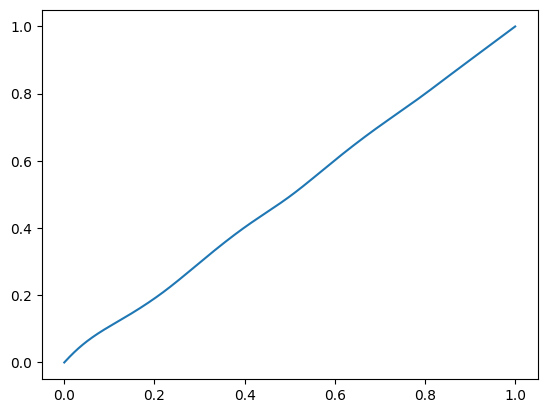

In [62]:
curve = trainer.export_curve()
plt.plot(curve['grid_x'], curve['grid_f'])

In [17]:
from deixis.face_utils.interpolate.age_sampling_utils import run_analysis
metrics_df, candidates_df, keys = run_analysis(per_bin=500, neighbor_k=64, device="mps")

candidates_df


ModuleNotFoundError: No module named 'deixis'

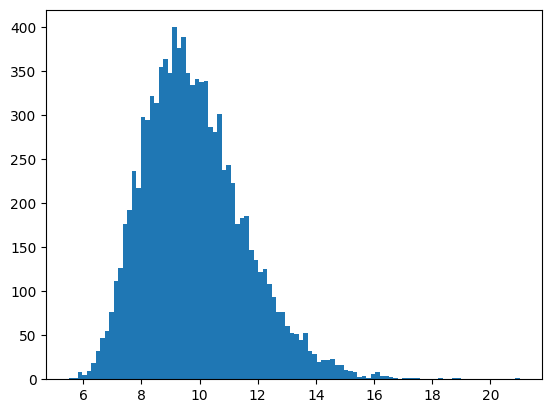

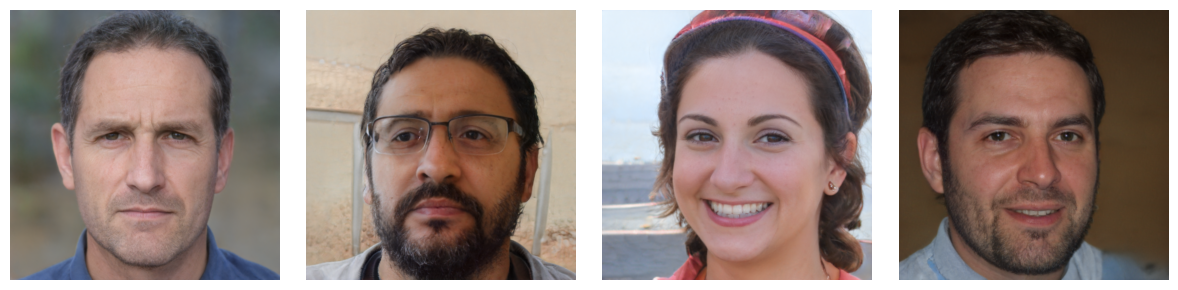

NameError: name 'latents_centered_norm' is not defined

In [ ]:
import matplotlib.pyplot as plt
diffs = []
t_norms = []
truncations = np.arange(0.99,1.01,0.01)
# for t in truncations:
#     w_candidates = G.mapping(torch.randn(10000, G.mapping.z_dim, device=G.mapping.w_avg.device), None, truncation_psi=t)[:,0] 
#     w_candidates_centered = w_candidates - G.mapping.w_avg
#     w_candidates_norm = w_candidates_centered.norm(dim=-1)
#     plt.hist(w_candidates_norm.cpu().numpy(), bins=100)
#     plt.show()
#     w_candidates_norm = w_candidates_norm.mean().item()
#     diff = w_candidates_norm - latents_centered_norm
#     diffs.append(diff)
#     t_norms.append(w_candidates_norm)

# plt.plot(truncations, diffs)
# plt.xlabel("Truncation")
# plt.ylabel("Difference in norm")
# plt.show()

w_candidates = G.mapping(torch.randn(10000, G.mapping.z_dim, device=G.mapping.w_avg.device), None, truncation_psi=1.0)[:,0] 
w_candidates_centered = w_candidates - G.mapping.w_avg
w_candidates_norm = w_candidates_centered.norm(dim=-1)
plt.hist(w_candidates_norm.cpu().numpy(), bins=100)
plt.show()

from manipy.stylegan.utils import show_faces
show_faces(latents[:4], _G=G)
show_faces((latents[:4].to(torch.device("mps"))- G.mapping.w_avg.view(1,-1))/latents_centered_norm*20+ G.mapping.w_avg.view(1,-1), _G=G)
faces75= sorted(os.listdir("/Users/adamsobieszek/Downloads/0.75"))
faces75= [f for f in faces75 if f.endswith(".jpg") or f.endswith(".png") or f.endswith(".jpeg")]
faces75= [str(os.path.join("/Users/adamsobieszek/Downloads/0.75", f)) for f in faces75]
show_faces(faces75[:4])
